# MLP 4 - CIFAR-10

In [1]:
import numpy as np
import cupy as cp
import pathlib
import pickle
import csv
import sys

In [2]:
sys.path.append(str(pathlib.Path('../../').resolve()))

In [3]:
from lib.experiments import train_test_experiment, build_MLP, build_augmentation_pipeline
from lib.utils.enums import NonLinearity, Initialization, Dataset, OptimizerName
from lib.utils.data import load_integer_dataset

## Experiments config

In [5]:
num_fc_layers = 4
num_fc_hidden = [3000, 3000, 3000]

In [6]:
dataset_config = dict(
    dataset=Dataset.CIFAR10.name,
    subsample_ratio=1.0,
    ohe_values=(0, 32),
    data_augmentation=True,
    normalize=True,
)

In [7]:
network_config = dict(
    num_fc_layers=num_fc_layers,
    num_fc_hidden=num_fc_hidden,
    non_linearity=NonLinearity.NITRO_LEAKY_RELU.name,
    init=Initialization.UNIFORM_KAIMING_LEAKY_RELU.name,
    dropout_rate=0.1,
    seed=42,
    dtype='int32',
    device='cuda',
    local_loss='pred',
    bias=False,
    debug=False,
)

In [8]:
training_config = dict(
    batch_size=64,
    num_epochs=150,
    lr_inv=512,
    lr_amp_factor=640,
    fwd_decay_inv=19_000,
    subnet_decay_inv=7500,
    optimizer=OptimizerName.INTEGER_SGD.name,
)

In [9]:
config = dataset_config | network_config | training_config

## Run the configuration

Files already downloaded and verified


Files already downloaded and verified


Training on 50000 samples


Data normalized. New statistics:
-  Min: [-123 -123 -105]
-  Max: [126 127 127]
- Mean: [0 0 0]
-  Std: [61 61 61]

Moved data to device: <CUDA Device 1>
Train set:  (50000, 3, 32, 32), (50000, 10)
Test set:   (10000, 3, 32, 32), (10000, 10)
Data types: (int8, int8)


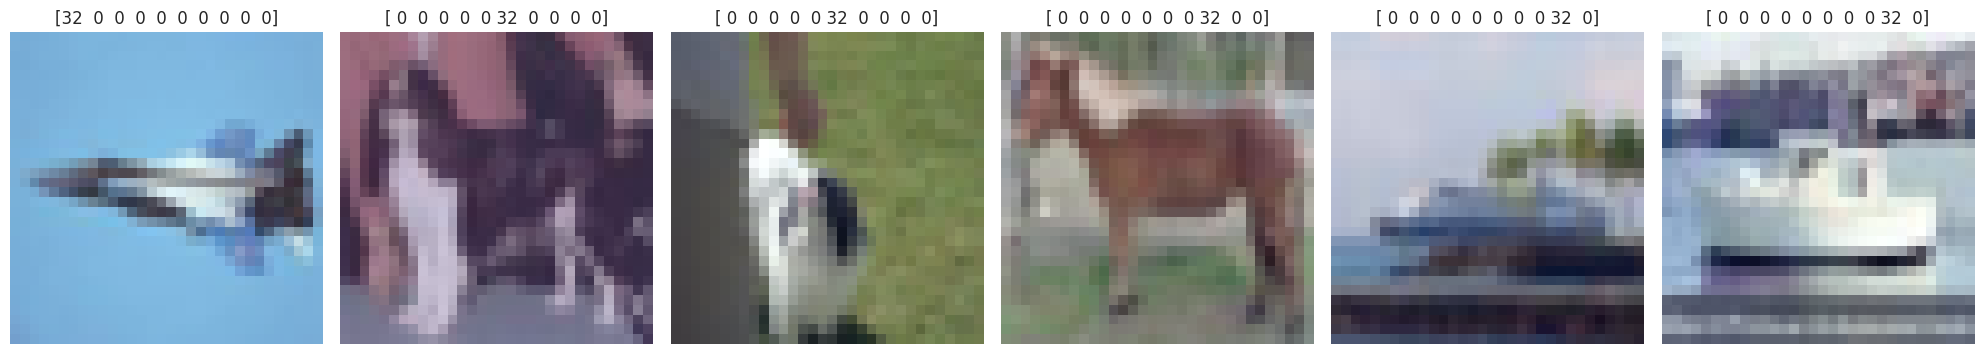

In [10]:
# Show the data and the model
dataset = load_integer_dataset(config, ohe_values=config["ohe_values"], val_dim=0, show_images=True, data_path='../.data')
X_train, _, _, y_train, _, _ = dataset

In [11]:
model = build_MLP(config, X_tr=X_train, y_tr=y_train)
print(model.extra_repr(1))

IntegerLocalLossMLP(
	(0): Sequential(
			(0): Flatten()
			(1): LocalLinearBlock(
			(0): IntegerLinear(in_features=3072, out_features=3000, bias=False, decay_rate_inv=19000)
			(1): ConstantScaling(fwd_factor=786432, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=3000, out_features=10, bias=False, decay_rate_inv=7500)
			(1): ConstantScaling(fwd_factor=768000, bwd_factor=1)
		)
	)
			(2): Dropout(dropout_rate=0.1)
			(3): LocalLinearBlock(
			(0): IntegerLinear(in_features=3000, out_features=3000, bias=False, decay_rate_inv=19000)
			(1): ConstantScaling(fwd_factor=768000, bwd_factor=1)
			(2): NitroLeakyReLU(negative_slope_inv=4)
			(learning_layers): Sequential(
			(0): IntegerLinear(in_features=3000, out_features=10, bias=False, decay_rate_inv=7500)
			(1): ConstantScaling(fwd_factor=768000, bwd_factor=1)
		)
	)
			(4): Dropout(dropout_rate=0.1)
			(5): LocalLinearBlock(
			(0): IntegerLinear(in_featur

In [12]:
def run_experiment(exp_config):
    # Setup reproducibility
    print(f"{'-' * 64}")
    print(f"Running experiment with seed {exp_config['seed']}...")
    np.random.seed(exp_config["seed"])
    cp.random.seed(exp_config["seed"])
    
    # Load the dataset
    data = load_integer_dataset(exp_config, ohe_values=exp_config["ohe_values"], val_dim=0, show_images=False, show_log=False, data_path='../.data')
    X_tr, _, X_test, y_tr, _, y_test = data

    # Setup data augmentation
    augmentation_pipeline = build_augmentation_pipeline(exp_config)
    
    # Build and train the model
    m = build_MLP(exp_config, X_tr=X_tr, y_tr=y_tr)    
    best_train_acc, best_test_acc = train_test_experiment(
        m, exp_config, X_tr=X_tr, X_te=X_test, y_tr=y_tr, y_te=y_test,
        augmentation_pipeline=augmentation_pipeline,
        show_local_accuracies=False, show_progress_bar=False
    )

    # Append the results to a CSV file
    with open('./results.csv', mode='a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([exp_config["seed"], best_train_acc, best_test_acc])
        
    # Save the first model
    if not pathlib.Path('model.pkl').exists():
        with open('model.pkl', 'wb') as f:
            pickle.dump(m, f)

In [13]:
N_EXPERIMENTS = 10
for i in range(N_EXPERIMENTS):
    run_experiment(config)
    config["seed"] += 1

----------------------------------------------------------------
Running experiment with seed 42...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.981% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 10.479% - Test accuracy: 16.216%


Epoch   3/150 - Train accuracy: 17.942% - Test accuracy: 17.999%


Epoch   4/150 - Train accuracy: 22.529% - Test accuracy: 28.045%


Epoch   5/150 - Train accuracy: 29.627% - Test accuracy: 37.420%


Epoch   6/150 - Train accuracy: 35.007% - Test accuracy: 40.655%


Epoch   7/150 - Train accuracy: 37.758% - Test accuracy: 41.476%


Epoch   8/150 - Train accuracy: 39.905% - Test accuracy: 44.671%


Epoch   9/150 - Train accuracy: 41.625% - Test accuracy: 44.732%


Epoch  10/150 - Train accuracy: 42.516% - Test accuracy: 45.913%


Epoch  11/150 - Train accuracy: 43.538% - Test accuracy: 46.775%


Epoch  12/150 - Train accuracy: 44.568% - Test accuracy: 47.336%


Epoch  13/150 - Train accuracy: 45.343% - Test accuracy: 48.147%


Epoch  14/150 - Train accuracy: 46.207% - Test accuracy: 50.020%


Epoch  15/150 - Train accuracy: 47.067% - Test accuracy: 49.549%


Epoch  16/150 - Train accuracy: 47.463% - Test accuracy: 50.681%


Epoch  17/150 - Train accuracy: 48.215% - Test accuracy: 51.212%


Epoch  18/150 - Train accuracy: 48.510% - Test accuracy: 51.102%


Epoch  19/150 - Train accuracy: 49.004% - Test accuracy: 51.903%


Epoch  20/150 - Train accuracy: 49.756% - Test accuracy: 52.474%


Epoch  21/150 - Train accuracy: 49.656% - Test accuracy: 53.586%


Epoch  22/150 - Train accuracy: 49.982% - Test accuracy: 53.245%


Epoch  23/150 - Train accuracy: 50.720% - Test accuracy: 53.135%


Epoch  24/150 - Train accuracy: 51.056% - Test accuracy: 53.766%


Epoch  25/150 - Train accuracy: 50.970% - Test accuracy: 53.456%


Epoch  26/150 - Train accuracy: 51.386% - Test accuracy: 54.617%


Epoch  27/150 - Train accuracy: 51.795% - Test accuracy: 54.167%


Epoch  28/150 - Train accuracy: 52.599% - Test accuracy: 54.497%


Epoch  29/150 - Train accuracy: 52.673% - Test accuracy: 54.698%


Epoch  30/150 - Train accuracy: 53.005% - Test accuracy: 55.038%


Epoch  31/150 - Train accuracy: 53.437% - Test accuracy: 55.619%


Epoch  32/150 - Train accuracy: 53.403% - Test accuracy: 55.118%


Epoch  33/150 - Train accuracy: 53.183% - Test accuracy: 55.499%


Epoch  34/150 - Train accuracy: 53.911% - Test accuracy: 54.417%


Epoch  35/150 - Train accuracy: 54.013% - Test accuracy: 55.559%


Epoch  36/150 - Train accuracy: 54.023% - Test accuracy: 55.970%


Epoch  37/150 - Train accuracy: 54.245% - Test accuracy: 56.050%


Epoch  38/150 - Train accuracy: 54.293% - Test accuracy: 55.519%


Epoch  39/150 - Train accuracy: 54.972% - Test accuracy: 56.060%


Epoch  40/150 - Train accuracy: 54.581% - Test accuracy: 55.809%


Epoch  41/150 - Train accuracy: 55.198% - Test accuracy: 55.899%


Epoch  42/150 - Train accuracy: 55.364% - Test accuracy: 56.540%


Epoch  43/150 - Train accuracy: 55.586% - Test accuracy: 56.781%


Epoch  44/150 - Train accuracy: 55.754% - Test accuracy: 56.320%


Epoch  45/150 - Train accuracy: 55.992% - Test accuracy: 56.651%


Epoch  46/150 - Train accuracy: 55.802% - Test accuracy: 56.821%


Epoch  47/150 - Train accuracy: 56.348% - Test accuracy: 57.732%


Epoch  48/150 - Train accuracy: 55.944% - Test accuracy: 57.312%


Epoch  49/150 - Train accuracy: 56.238% - Test accuracy: 57.001%


Epoch  50/150 - Train accuracy: 56.792% - Test accuracy: 55.759%


Epoch  51/150 - Train accuracy: 57.132% - Test accuracy: 57.442%


Epoch  52/150 - Train accuracy: 56.788% - Test accuracy: 56.591%


Epoch  53/150 - Train accuracy: 57.228% - Test accuracy: 57.232%


Epoch  54/150 - Train accuracy: 56.992% - Test accuracy: 57.472%


Epoch  55/150 - Train accuracy: 57.624% - Test accuracy: 56.951%


Epoch  56/150 - Train accuracy: 58.497% - Test accuracy: 57.853%


Epoch  57/150 - Train accuracy: 57.568% - Test accuracy: 58.253%


Epoch  58/150 - Train accuracy: 57.236% - Test accuracy: 56.781%


Epoch  59/150 - Train accuracy: 58.487% - Test accuracy: 57.472%


Epoch  60/150 - Train accuracy: 58.109% - Test accuracy: 57.071%


Epoch  61/150 - Train accuracy: 57.967% - Test accuracy: 57.883%


Epoch  62/150 - Train accuracy: 58.557% - Test accuracy: 57.212%


Epoch  63/150 - Train accuracy: 58.679% - Test accuracy: 56.751%


Epoch  64/150 - Train accuracy: 58.589% - Test accuracy: 58.303%


Epoch  65/150 - Train accuracy: 58.985% - Test accuracy: 58.213%


Epoch  66/150 - Train accuracy: 59.003% - Test accuracy: 57.222%


Epoch  67/150 - Train accuracy: 59.307% - Test accuracy: 58.323%


Epoch  68/150 - Train accuracy: 59.475% - Test accuracy: 58.283%


Epoch  69/150 - Train accuracy: 59.391% - Test accuracy: 56.581%


Epoch  70/150 - Train accuracy: 59.881% - Test accuracy: 58.403%


Epoch  71/150 - Train accuracy: 59.051% - Test accuracy: 58.083%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 71
----------------------------------------------------------------


Epoch  72/150 - Train accuracy: 62.232% - Test accuracy: 60.036%


Epoch  73/150 - Train accuracy: 62.334% - Test accuracy: 60.086%


Epoch  74/150 - Train accuracy: 62.538% - Test accuracy: 60.056%


Epoch  75/150 - Train accuracy: 63.032% - Test accuracy: 60.176%


Epoch  76/150 - Train accuracy: 62.966% - Test accuracy: 60.387%


Epoch  77/150 - Train accuracy: 63.134% - Test accuracy: 60.327%


Epoch  78/150 - Train accuracy: 62.550% - Test accuracy: 60.377%


Epoch  79/150 - Train accuracy: 63.622% - Test accuracy: 60.036%


Epoch  80/150 - Train accuracy: 63.542% - Test accuracy: 60.567%


Epoch  81/150 - Train accuracy: 63.544% - Test accuracy: 60.337%


Epoch  82/150 - Train accuracy: 63.548% - Test accuracy: 60.697%


Epoch  83/150 - Train accuracy: 63.450% - Test accuracy: 59.886%


Epoch  84/150 - Train accuracy: 63.596% - Test accuracy: 60.727%


Epoch  85/150 - Train accuracy: 63.698% - Test accuracy: 60.327%


Epoch  86/150 - Train accuracy: 63.934% - Test accuracy: 60.417%


Epoch  87/150 - Train accuracy: 63.576% - Test accuracy: 60.677%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 87
----------------------------------------------------------------


Epoch  88/150 - Train accuracy: 64.543% - Test accuracy: 61.208%


Epoch  89/150 - Train accuracy: 65.085% - Test accuracy: 61.128%


Epoch  90/150 - Train accuracy: 64.559% - Test accuracy: 60.837%


Epoch  91/150 - Train accuracy: 64.727% - Test accuracy: 60.927%


Epoch  92/150 - Train accuracy: 65.163% - Test accuracy: 60.877%


Epoch  93/150 - Train accuracy: 64.979% - Test accuracy: 60.737%


Epoch  94/150 - Train accuracy: 64.813% - Test accuracy: 61.248%


Epoch  95/150 - Train accuracy: 64.667% - Test accuracy: 60.777%


Epoch  96/150 - Train accuracy: 64.955% - Test accuracy: 61.028%


Epoch  97/150 - Train accuracy: 64.915% - Test accuracy: 60.757%


Epoch  98/150 - Train accuracy: 64.667% - Test accuracy: 60.948%


Epoch  99/150 - Train accuracy: 64.765% - Test accuracy: 60.938%


Epoch 100/150 - Train accuracy: 64.759% - Test accuracy: 61.258%


Epoch 101/150 - Train accuracy: 64.961% - Test accuracy: 61.098%


Epoch 102/150 - Train accuracy: 65.913% - Test accuracy: 60.807%


Epoch 103/150 - Train accuracy: 65.149% - Test accuracy: 61.008%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 103
----------------------------------------------------------------


Epoch 104/150 - Train accuracy: 65.441% - Test accuracy: 61.078%


Epoch 105/150 - Train accuracy: 65.265% - Test accuracy: 60.968%


Epoch 106/150 - Train accuracy: 65.867% - Test accuracy: 61.108%


Epoch 107/150 - Train accuracy: 65.183% - Test accuracy: 60.897%


Epoch 108/150 - Train accuracy: 65.681% - Test accuracy: 61.038%


Epoch 109/150 - Train accuracy: 65.289% - Test accuracy: 60.978%


Epoch 110/150 - Train accuracy: 65.509% - Test accuracy: 61.078%


Epoch 111/150 - Train accuracy: 65.289% - Test accuracy: 60.958%


Epoch 112/150 - Train accuracy: 65.345% - Test accuracy: 60.897%


Epoch 113/150 - Train accuracy: 65.107% - Test accuracy: 60.948%


Epoch 114/150 - Train accuracy: 65.129% - Test accuracy: 61.058%


Epoch 115/150 - Train accuracy: 65.431% - Test accuracy: 61.018%


Epoch 116/150 - Train accuracy: 65.307% - Test accuracy: 61.048%


Epoch 117/150 - Train accuracy: 65.979% - Test accuracy: 60.938%


Epoch 118/150 - Train accuracy: 65.791% - Test accuracy: 60.958%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 118
----------------------------------------------------------------


Epoch 119/150 - Train accuracy: 66.351% - Test accuracy: 61.058%


Epoch 120/150 - Train accuracy: 65.813% - Test accuracy: 61.058%


Epoch 121/150 - Train accuracy: 65.867% - Test accuracy: 61.048%


Epoch 122/150 - Train accuracy: 65.871% - Test accuracy: 61.038%


Epoch 123/150 - Train accuracy: 65.131% - Test accuracy: 61.018%
----------------------------------------------------------------
Early stopping at epoch 123
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 43...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.135% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 09.809% - Test accuracy: 09.986%


Epoch   3/150 - Train accuracy: 16.909% - Test accuracy: 19.511%


Epoch   4/150 - Train accuracy: 22.269% - Test accuracy: 24.259%


Epoch   5/150 - Train accuracy: 28.231% - Test accuracy: 36.759%


Epoch   6/150 - Train accuracy: 34.987% - Test accuracy: 39.854%


Epoch   7/150 - Train accuracy: 37.810% - Test accuracy: 41.587%


Epoch   8/150 - Train accuracy: 40.189% - Test accuracy: 44.401%


Epoch   9/150 - Train accuracy: 41.145% - Test accuracy: 44.551%


Epoch  10/150 - Train accuracy: 41.967% - Test accuracy: 47.055%


Epoch  11/150 - Train accuracy: 43.412% - Test accuracy: 48.197%


Epoch  12/150 - Train accuracy: 44.522% - Test accuracy: 47.646%


Epoch  13/150 - Train accuracy: 45.491% - Test accuracy: 48.788%


Epoch  14/150 - Train accuracy: 46.369% - Test accuracy: 50.030%


Epoch  15/150 - Train accuracy: 46.971% - Test accuracy: 51.082%


Epoch  16/150 - Train accuracy: 47.433% - Test accuracy: 50.581%


Epoch  17/150 - Train accuracy: 47.719% - Test accuracy: 50.791%


Epoch  18/150 - Train accuracy: 48.578% - Test accuracy: 50.551%


Epoch  19/150 - Train accuracy: 48.948% - Test accuracy: 52.053%


Epoch  20/150 - Train accuracy: 49.314% - Test accuracy: 51.653%


Epoch  21/150 - Train accuracy: 49.714% - Test accuracy: 52.724%


Epoch  22/150 - Train accuracy: 49.988% - Test accuracy: 52.714%


Epoch  23/150 - Train accuracy: 50.038% - Test accuracy: 53.846%


Epoch  24/150 - Train accuracy: 50.984% - Test accuracy: 52.975%


Epoch  25/150 - Train accuracy: 50.708% - Test accuracy: 54.137%


Epoch  26/150 - Train accuracy: 51.210% - Test accuracy: 54.257%


Epoch  27/150 - Train accuracy: 51.977% - Test accuracy: 53.816%


Epoch  28/150 - Train accuracy: 52.485% - Test accuracy: 54.838%


Epoch  29/150 - Train accuracy: 52.091% - Test accuracy: 54.117%


Epoch  30/150 - Train accuracy: 52.709% - Test accuracy: 54.918%


Epoch  31/150 - Train accuracy: 52.945% - Test accuracy: 54.367%


Epoch  32/150 - Train accuracy: 52.991% - Test accuracy: 54.056%


Epoch  33/150 - Train accuracy: 53.049% - Test accuracy: 55.659%


Epoch  34/150 - Train accuracy: 53.093% - Test accuracy: 55.429%


Epoch  35/150 - Train accuracy: 53.681% - Test accuracy: 55.489%


Epoch  36/150 - Train accuracy: 53.609% - Test accuracy: 55.749%


Epoch  37/150 - Train accuracy: 53.947% - Test accuracy: 55.158%


Epoch  38/150 - Train accuracy: 54.203% - Test accuracy: 55.859%


Epoch  39/150 - Train accuracy: 55.304% - Test accuracy: 56.520%


Epoch  40/150 - Train accuracy: 54.890% - Test accuracy: 56.080%


Epoch  41/150 - Train accuracy: 54.692% - Test accuracy: 56.310%


Epoch  42/150 - Train accuracy: 54.748% - Test accuracy: 56.651%


Epoch  43/150 - Train accuracy: 55.006% - Test accuracy: 56.230%


Epoch  44/150 - Train accuracy: 55.522% - Test accuracy: 57.061%


Epoch  45/150 - Train accuracy: 55.106% - Test accuracy: 55.739%


Epoch  46/150 - Train accuracy: 55.856% - Test accuracy: 57.572%


Epoch  47/150 - Train accuracy: 55.762% - Test accuracy: 56.881%


Epoch  48/150 - Train accuracy: 56.318% - Test accuracy: 56.781%


Epoch  49/150 - Train accuracy: 56.050% - Test accuracy: 57.843%


Epoch  50/150 - Train accuracy: 55.744% - Test accuracy: 56.550%


Epoch  51/150 - Train accuracy: 56.656% - Test accuracy: 56.581%


Epoch  52/150 - Train accuracy: 56.496% - Test accuracy: 57.632%


Epoch  53/150 - Train accuracy: 56.322% - Test accuracy: 56.651%


Epoch  54/150 - Train accuracy: 56.500% - Test accuracy: 57.342%


Epoch  55/150 - Train accuracy: 57.320% - Test accuracy: 56.450%


Epoch  56/150 - Train accuracy: 56.998% - Test accuracy: 57.302%


Epoch  57/150 - Train accuracy: 57.184% - Test accuracy: 57.121%


Epoch  58/150 - Train accuracy: 57.835% - Test accuracy: 57.612%


Epoch  59/150 - Train accuracy: 56.604% - Test accuracy: 57.432%


Epoch  60/150 - Train accuracy: 57.510% - Test accuracy: 57.432%


Epoch  61/150 - Train accuracy: 57.985% - Test accuracy: 57.502%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 61
----------------------------------------------------------------


Epoch  62/150 - Train accuracy: 60.601% - Test accuracy: 58.824%


Epoch  63/150 - Train accuracy: 60.467% - Test accuracy: 58.584%


Epoch  64/150 - Train accuracy: 61.386% - Test accuracy: 59.275%


Epoch  65/150 - Train accuracy: 60.731% - Test accuracy: 59.235%


Epoch  66/150 - Train accuracy: 61.570% - Test accuracy: 59.185%


Epoch  67/150 - Train accuracy: 61.596% - Test accuracy: 59.185%


Epoch  68/150 - Train accuracy: 60.791% - Test accuracy: 59.415%


Epoch  69/150 - Train accuracy: 61.554% - Test accuracy: 59.726%


Epoch  70/150 - Train accuracy: 61.210% - Test accuracy: 59.395%


Epoch  71/150 - Train accuracy: 62.282% - Test accuracy: 59.575%


Epoch  72/150 - Train accuracy: 61.196% - Test accuracy: 59.665%


Epoch  73/150 - Train accuracy: 62.212% - Test accuracy: 59.635%


Epoch  74/150 - Train accuracy: 62.182% - Test accuracy: 59.345%


Epoch  75/150 - Train accuracy: 61.970% - Test accuracy: 59.836%


Epoch  76/150 - Train accuracy: 61.632% - Test accuracy: 60.176%


Epoch  77/150 - Train accuracy: 62.510% - Test accuracy: 59.836%


Epoch  78/150 - Train accuracy: 62.400% - Test accuracy: 59.716%


Epoch  79/150 - Train accuracy: 62.188% - Test accuracy: 60.116%


Epoch  80/150 - Train accuracy: 62.120% - Test accuracy: 59.665%


Epoch  81/150 - Train accuracy: 62.154% - Test accuracy: 59.896%


Epoch  82/150 - Train accuracy: 62.788% - Test accuracy: 60.256%


Epoch  83/150 - Train accuracy: 62.226% - Test accuracy: 59.896%


Epoch  84/150 - Train accuracy: 62.548% - Test accuracy: 60.557%


Epoch  85/150 - Train accuracy: 62.564% - Test accuracy: 60.126%


Epoch  86/150 - Train accuracy: 62.632% - Test accuracy: 59.706%


Epoch  87/150 - Train accuracy: 62.644% - Test accuracy: 60.066%


Epoch  88/150 - Train accuracy: 62.344% - Test accuracy: 60.517%


Epoch  89/150 - Train accuracy: 63.354% - Test accuracy: 60.046%


Epoch  90/150 - Train accuracy: 62.364% - Test accuracy: 60.236%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 62.896% - Test accuracy: 60.877%


Epoch  92/150 - Train accuracy: 63.916% - Test accuracy: 60.887%


Epoch  93/150 - Train accuracy: 64.833% - Test accuracy: 60.787%


Epoch  94/150 - Train accuracy: 64.481% - Test accuracy: 60.958%


Epoch  95/150 - Train accuracy: 63.868% - Test accuracy: 60.827%


Epoch  96/150 - Train accuracy: 64.503% - Test accuracy: 60.857%


Epoch  97/150 - Train accuracy: 64.773% - Test accuracy: 60.887%


Epoch  98/150 - Train accuracy: 64.409% - Test accuracy: 60.907%


Epoch  99/150 - Train accuracy: 63.746% - Test accuracy: 60.587%


Epoch 100/150 - Train accuracy: 64.581% - Test accuracy: 60.707%


Epoch 101/150 - Train accuracy: 64.413% - Test accuracy: 60.777%


Epoch 102/150 - Train accuracy: 64.323% - Test accuracy: 60.767%


Epoch 103/150 - Train accuracy: 64.479% - Test accuracy: 60.757%


Epoch 104/150 - Train accuracy: 64.052% - Test accuracy: 60.697%


Epoch 105/150 - Train accuracy: 64.347% - Test accuracy: 61.068%


Epoch 106/150 - Train accuracy: 63.672% - Test accuracy: 61.088%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 106
----------------------------------------------------------------


Epoch 107/150 - Train accuracy: 64.545% - Test accuracy: 61.038%


Epoch 108/150 - Train accuracy: 64.829% - Test accuracy: 61.138%


Epoch 109/150 - Train accuracy: 64.765% - Test accuracy: 60.978%


Epoch 110/150 - Train accuracy: 64.687% - Test accuracy: 60.958%


Epoch 111/150 - Train accuracy: 64.603% - Test accuracy: 60.998%


Epoch 112/150 - Train accuracy: 64.685% - Test accuracy: 61.108%


Epoch 113/150 - Train accuracy: 65.271% - Test accuracy: 60.978%


Epoch 114/150 - Train accuracy: 64.239% - Test accuracy: 61.238%


Epoch 115/150 - Train accuracy: 64.805% - Test accuracy: 60.847%


Epoch 116/150 - Train accuracy: 64.637% - Test accuracy: 60.978%


Epoch 117/150 - Train accuracy: 64.557% - Test accuracy: 60.998%


Epoch 118/150 - Train accuracy: 64.351% - Test accuracy: 61.008%


Epoch 119/150 - Train accuracy: 64.283% - Test accuracy: 61.218%


Epoch 120/150 - Train accuracy: 64.383% - Test accuracy: 60.897%


Epoch 121/150 - Train accuracy: 64.639% - Test accuracy: 61.088%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 121
----------------------------------------------------------------


Epoch 122/150 - Train accuracy: 65.153% - Test accuracy: 61.058%


Epoch 123/150 - Train accuracy: 64.927% - Test accuracy: 61.128%


Epoch 124/150 - Train accuracy: 64.891% - Test accuracy: 61.168%


Epoch 125/150 - Train accuracy: 64.573% - Test accuracy: 61.108%


Epoch 126/150 - Train accuracy: 64.457% - Test accuracy: 61.118%
----------------------------------------------------------------
Early stopping at epoch 126
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 44...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.219% - Test accuracy: 09.996%


Epoch   2/150 - Train accuracy: 10.101% - Test accuracy: 10.006%


Epoch   3/150 - Train accuracy: 15.033% - Test accuracy: 19.111%


Epoch   4/150 - Train accuracy: 21.913% - Test accuracy: 24.940%


Epoch   5/150 - Train accuracy: 26.440% - Test accuracy: 33.403%


Epoch   6/150 - Train accuracy: 33.849% - Test accuracy: 38.351%


Epoch   7/150 - Train accuracy: 37.272% - Test accuracy: 41.386%


Epoch   8/150 - Train accuracy: 39.693% - Test accuracy: 43.840%


Epoch   9/150 - Train accuracy: 41.447% - Test accuracy: 44.852%


Epoch  10/150 - Train accuracy: 42.342% - Test accuracy: 45.853%


Epoch  11/150 - Train accuracy: 43.356% - Test accuracy: 47.616%


Epoch  12/150 - Train accuracy: 44.210% - Test accuracy: 47.185%


Epoch  13/150 - Train accuracy: 45.359% - Test accuracy: 49.439%


Epoch  14/150 - Train accuracy: 46.523% - Test accuracy: 49.910%


Epoch  15/150 - Train accuracy: 46.873% - Test accuracy: 50.331%


Epoch  16/150 - Train accuracy: 47.175% - Test accuracy: 51.002%


Epoch  17/150 - Train accuracy: 47.817% - Test accuracy: 51.112%


Epoch  18/150 - Train accuracy: 48.690% - Test accuracy: 51.963%


Epoch  19/150 - Train accuracy: 48.668% - Test accuracy: 52.264%


Epoch  20/150 - Train accuracy: 49.274% - Test accuracy: 52.234%


Epoch  21/150 - Train accuracy: 49.606% - Test accuracy: 53.045%


Epoch  22/150 - Train accuracy: 49.770% - Test accuracy: 53.145%


Epoch  23/150 - Train accuracy: 50.874% - Test accuracy: 53.916%


Epoch  24/150 - Train accuracy: 50.926% - Test accuracy: 53.165%


Epoch  25/150 - Train accuracy: 51.018% - Test accuracy: 53.045%


Epoch  26/150 - Train accuracy: 52.091% - Test accuracy: 54.417%


Epoch  27/150 - Train accuracy: 51.470% - Test accuracy: 53.836%


Epoch  28/150 - Train accuracy: 51.687% - Test accuracy: 54.728%


Epoch  29/150 - Train accuracy: 52.239% - Test accuracy: 54.507%


Epoch  30/150 - Train accuracy: 52.219% - Test accuracy: 54.798%


Epoch  31/150 - Train accuracy: 52.947% - Test accuracy: 55.058%


Epoch  32/150 - Train accuracy: 53.299% - Test accuracy: 54.758%


Epoch  33/150 - Train accuracy: 53.199% - Test accuracy: 54.607%


Epoch  34/150 - Train accuracy: 53.475% - Test accuracy: 54.457%


Epoch  35/150 - Train accuracy: 54.525% - Test accuracy: 56.050%


Epoch  36/150 - Train accuracy: 53.939% - Test accuracy: 55.669%


Epoch  37/150 - Train accuracy: 54.277% - Test accuracy: 56.250%


Epoch  38/150 - Train accuracy: 54.313% - Test accuracy: 55.970%


Epoch  39/150 - Train accuracy: 54.483% - Test accuracy: 55.859%


Epoch  40/150 - Train accuracy: 54.257% - Test accuracy: 56.380%


Epoch  41/150 - Train accuracy: 54.401% - Test accuracy: 55.399%


Epoch  42/150 - Train accuracy: 55.350% - Test accuracy: 55.789%


Epoch  43/150 - Train accuracy: 55.832% - Test accuracy: 55.899%


Epoch  44/150 - Train accuracy: 55.200% - Test accuracy: 57.302%


Epoch  45/150 - Train accuracy: 55.624% - Test accuracy: 56.741%


Epoch  46/150 - Train accuracy: 55.978% - Test accuracy: 56.540%


Epoch  47/150 - Train accuracy: 56.190% - Test accuracy: 56.440%


Epoch  48/150 - Train accuracy: 56.402% - Test accuracy: 56.911%


Epoch  49/150 - Train accuracy: 56.616% - Test accuracy: 56.751%


Epoch  50/150 - Train accuracy: 56.164% - Test accuracy: 56.791%


Epoch  51/150 - Train accuracy: 56.656% - Test accuracy: 57.212%


Epoch  52/150 - Train accuracy: 56.878% - Test accuracy: 54.497%


Epoch  53/150 - Train accuracy: 57.052% - Test accuracy: 57.141%


Epoch  54/150 - Train accuracy: 56.678% - Test accuracy: 56.981%


Epoch  55/150 - Train accuracy: 57.432% - Test accuracy: 57.652%


Epoch  56/150 - Train accuracy: 57.436% - Test accuracy: 57.692%


Epoch  57/150 - Train accuracy: 57.424% - Test accuracy: 57.732%


Epoch  58/150 - Train accuracy: 57.690% - Test accuracy: 57.011%


Epoch  59/150 - Train accuracy: 57.218% - Test accuracy: 58.283%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 59
----------------------------------------------------------------


Epoch  60/150 - Train accuracy: 60.251% - Test accuracy: 59.455%


Epoch  61/150 - Train accuracy: 60.835% - Test accuracy: 59.525%


Epoch  62/150 - Train accuracy: 60.737% - Test accuracy: 59.465%


Epoch  63/150 - Train accuracy: 61.672% - Test accuracy: 59.395%


Epoch  64/150 - Train accuracy: 61.084% - Test accuracy: 59.535%


Epoch  65/150 - Train accuracy: 61.822% - Test accuracy: 59.766%


Epoch  66/150 - Train accuracy: 61.534% - Test accuracy: 59.445%


Epoch  67/150 - Train accuracy: 61.322% - Test accuracy: 59.395%


Epoch  68/150 - Train accuracy: 61.924% - Test accuracy: 59.355%


Epoch  69/150 - Train accuracy: 61.708% - Test accuracy: 59.696%


Epoch  70/150 - Train accuracy: 62.142% - Test accuracy: 59.615%


Epoch  71/150 - Train accuracy: 61.148% - Test accuracy: 59.836%


Epoch  72/150 - Train accuracy: 61.598% - Test accuracy: 59.495%


Epoch  73/150 - Train accuracy: 61.608% - Test accuracy: 59.665%


Epoch  74/150 - Train accuracy: 61.708% - Test accuracy: 59.726%


Epoch  75/150 - Train accuracy: 61.798% - Test accuracy: 60.106%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 75
----------------------------------------------------------------


Epoch  76/150 - Train accuracy: 62.504% - Test accuracy: 59.956%


Epoch  77/150 - Train accuracy: 63.082% - Test accuracy: 60.156%


Epoch  78/150 - Train accuracy: 62.882% - Test accuracy: 60.096%


Epoch  79/150 - Train accuracy: 62.958% - Test accuracy: 60.487%


Epoch  80/150 - Train accuracy: 63.296% - Test accuracy: 60.407%


Epoch  81/150 - Train accuracy: 63.194% - Test accuracy: 60.076%


Epoch  82/150 - Train accuracy: 62.980% - Test accuracy: 60.477%


Epoch  83/150 - Train accuracy: 62.390% - Test accuracy: 60.377%


Epoch  84/150 - Train accuracy: 62.960% - Test accuracy: 60.306%


Epoch  85/150 - Train accuracy: 63.070% - Test accuracy: 60.547%


Epoch  86/150 - Train accuracy: 63.090% - Test accuracy: 60.497%


Epoch  87/150 - Train accuracy: 62.962% - Test accuracy: 60.557%


Epoch  88/150 - Train accuracy: 62.670% - Test accuracy: 60.687%


Epoch  89/150 - Train accuracy: 63.108% - Test accuracy: 60.367%


Epoch  90/150 - Train accuracy: 62.996% - Test accuracy: 60.387%


Epoch  91/150 - Train accuracy: 63.368% - Test accuracy: 60.447%


Epoch  92/150 - Train accuracy: 63.132% - Test accuracy: 60.286%


Epoch  93/150 - Train accuracy: 63.180% - Test accuracy: 60.086%


Epoch  94/150 - Train accuracy: 62.634% - Test accuracy: 60.437%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 94
----------------------------------------------------------------


Epoch  95/150 - Train accuracy: 63.828% - Test accuracy: 60.547%


Epoch  96/150 - Train accuracy: 64.103% - Test accuracy: 60.627%


Epoch  97/150 - Train accuracy: 64.153% - Test accuracy: 60.447%


Epoch  98/150 - Train accuracy: 63.848% - Test accuracy: 60.637%


Epoch  99/150 - Train accuracy: 63.964% - Test accuracy: 60.597%


Epoch 100/150 - Train accuracy: 63.856% - Test accuracy: 60.697%


Epoch 101/150 - Train accuracy: 63.900% - Test accuracy: 60.547%


Epoch 102/150 - Train accuracy: 64.119% - Test accuracy: 60.577%


Epoch 103/150 - Train accuracy: 63.130% - Test accuracy: 60.437%


Epoch 104/150 - Train accuracy: 64.044% - Test accuracy: 60.697%


Epoch 105/150 - Train accuracy: 63.870% - Test accuracy: 60.697%


Epoch 106/150 - Train accuracy: 63.866% - Test accuracy: 60.427%


Epoch 107/150 - Train accuracy: 63.850% - Test accuracy: 60.607%


Epoch 108/150 - Train accuracy: 63.492% - Test accuracy: 60.467%


Epoch 109/150 - Train accuracy: 64.004% - Test accuracy: 60.497%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 109
----------------------------------------------------------------


Epoch 110/150 - Train accuracy: 63.342% - Test accuracy: 60.537%


Epoch 111/150 - Train accuracy: 63.626% - Test accuracy: 60.487%


Epoch 112/150 - Train accuracy: 64.251% - Test accuracy: 60.637%


Epoch 113/150 - Train accuracy: 63.502% - Test accuracy: 60.617%


Epoch 114/150 - Train accuracy: 63.600% - Test accuracy: 60.517%
----------------------------------------------------------------
Early stopping at epoch 114
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 45...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.885% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 09.945% - Test accuracy: 10.006%


Epoch   3/150 - Train accuracy: 16.731% - Test accuracy: 19.431%


Epoch   4/150 - Train accuracy: 22.247% - Test accuracy: 27.424%


Epoch   5/150 - Train accuracy: 29.659% - Test accuracy: 37.009%


Epoch   6/150 - Train accuracy: 35.469% - Test accuracy: 40.094%


Epoch   7/150 - Train accuracy: 38.266% - Test accuracy: 41.937%


Epoch   8/150 - Train accuracy: 40.373% - Test accuracy: 44.681%


Epoch   9/150 - Train accuracy: 41.491% - Test accuracy: 45.112%


Epoch  10/150 - Train accuracy: 42.888% - Test accuracy: 45.893%


Epoch  11/150 - Train accuracy: 43.478% - Test accuracy: 47.376%


Epoch  12/150 - Train accuracy: 44.394% - Test accuracy: 48.087%


Epoch  13/150 - Train accuracy: 45.527% - Test accuracy: 47.726%


Epoch  14/150 - Train accuracy: 46.087% - Test accuracy: 48.297%


Epoch  15/150 - Train accuracy: 46.699% - Test accuracy: 49.880%


Epoch  16/150 - Train accuracy: 47.501% - Test accuracy: 51.573%


Epoch  17/150 - Train accuracy: 48.011% - Test accuracy: 50.881%


Epoch  18/150 - Train accuracy: 48.183% - Test accuracy: 51.723%


Epoch  19/150 - Train accuracy: 48.720% - Test accuracy: 52.434%


Epoch  20/150 - Train accuracy: 49.836% - Test accuracy: 52.183%


Epoch  21/150 - Train accuracy: 49.392% - Test accuracy: 52.284%


Epoch  22/150 - Train accuracy: 50.040% - Test accuracy: 53.005%


Epoch  23/150 - Train accuracy: 50.666% - Test accuracy: 52.915%


Epoch  24/150 - Train accuracy: 51.146% - Test accuracy: 53.626%


Epoch  25/150 - Train accuracy: 51.004% - Test accuracy: 53.666%


Epoch  26/150 - Train accuracy: 51.685% - Test accuracy: 54.507%


Epoch  27/150 - Train accuracy: 51.344% - Test accuracy: 54.046%


Epoch  28/150 - Train accuracy: 51.847% - Test accuracy: 54.477%


Epoch  29/150 - Train accuracy: 52.057% - Test accuracy: 54.036%


Epoch  30/150 - Train accuracy: 52.605% - Test accuracy: 53.506%


Epoch  31/150 - Train accuracy: 52.703% - Test accuracy: 55.008%


Epoch  32/150 - Train accuracy: 52.347% - Test accuracy: 55.859%


Epoch  33/150 - Train accuracy: 53.463% - Test accuracy: 55.849%


Epoch  34/150 - Train accuracy: 53.551% - Test accuracy: 55.489%


Epoch  35/150 - Train accuracy: 52.949% - Test accuracy: 55.679%


Epoch  36/150 - Train accuracy: 53.885% - Test accuracy: 55.479%


Epoch  37/150 - Train accuracy: 53.653% - Test accuracy: 55.469%


Epoch  38/150 - Train accuracy: 54.085% - Test accuracy: 56.060%


Epoch  39/150 - Train accuracy: 54.796% - Test accuracy: 56.110%


Epoch  40/150 - Train accuracy: 54.698% - Test accuracy: 56.270%


Epoch  41/150 - Train accuracy: 55.086% - Test accuracy: 54.798%


Epoch  42/150 - Train accuracy: 54.960% - Test accuracy: 56.380%


Epoch  43/150 - Train accuracy: 54.784% - Test accuracy: 55.839%


Epoch  44/150 - Train accuracy: 54.872% - Test accuracy: 57.021%


Epoch  45/150 - Train accuracy: 55.674% - Test accuracy: 57.252%


Epoch  46/150 - Train accuracy: 55.658% - Test accuracy: 56.400%


Epoch  47/150 - Train accuracy: 56.114% - Test accuracy: 56.360%


Epoch  48/150 - Train accuracy: 56.010% - Test accuracy: 56.601%


Epoch  49/150 - Train accuracy: 56.106% - Test accuracy: 56.170%


Epoch  50/150 - Train accuracy: 56.224% - Test accuracy: 55.799%


Epoch  51/150 - Train accuracy: 56.134% - Test accuracy: 56.651%


Epoch  52/150 - Train accuracy: 56.476% - Test accuracy: 57.131%


Epoch  53/150 - Train accuracy: 56.108% - Test accuracy: 56.961%


Epoch  54/150 - Train accuracy: 56.758% - Test accuracy: 56.871%


Epoch  55/150 - Train accuracy: 56.758% - Test accuracy: 57.722%


Epoch  56/150 - Train accuracy: 57.306% - Test accuracy: 57.772%


Epoch  57/150 - Train accuracy: 57.520% - Test accuracy: 57.482%


Epoch  58/150 - Train accuracy: 57.184% - Test accuracy: 56.581%


Epoch  59/150 - Train accuracy: 57.853% - Test accuracy: 58.123%


Epoch  60/150 - Train accuracy: 57.296% - Test accuracy: 56.901%


Epoch  61/150 - Train accuracy: 58.231% - Test accuracy: 56.380%


Epoch  62/150 - Train accuracy: 58.167% - Test accuracy: 56.731%


Epoch  63/150 - Train accuracy: 58.875% - Test accuracy: 58.113%


Epoch  64/150 - Train accuracy: 58.925% - Test accuracy: 57.652%


Epoch  65/150 - Train accuracy: 57.973% - Test accuracy: 57.602%


Epoch  66/150 - Train accuracy: 58.489% - Test accuracy: 58.774%


Epoch  67/150 - Train accuracy: 58.459% - Test accuracy: 57.432%


Epoch  68/150 - Train accuracy: 58.627% - Test accuracy: 58.333%


Epoch  69/150 - Train accuracy: 59.009% - Test accuracy: 57.692%


Epoch  70/150 - Train accuracy: 58.983% - Test accuracy: 57.642%


Epoch  71/150 - Train accuracy: 58.411% - Test accuracy: 58.153%


Epoch  72/150 - Train accuracy: 59.101% - Test accuracy: 58.704%


Epoch  73/150 - Train accuracy: 58.617% - Test accuracy: 58.594%


Epoch  74/150 - Train accuracy: 59.327% - Test accuracy: 57.983%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 74
----------------------------------------------------------------


Epoch  75/150 - Train accuracy: 61.474% - Test accuracy: 59.976%


Epoch  76/150 - Train accuracy: 62.340% - Test accuracy: 60.006%


Epoch  77/150 - Train accuracy: 62.876% - Test accuracy: 60.126%


Epoch  78/150 - Train accuracy: 62.752% - Test accuracy: 59.846%


Epoch  79/150 - Train accuracy: 62.930% - Test accuracy: 60.156%


Epoch  80/150 - Train accuracy: 63.238% - Test accuracy: 59.956%


Epoch  81/150 - Train accuracy: 63.076% - Test accuracy: 60.397%


Epoch  82/150 - Train accuracy: 63.456% - Test accuracy: 60.467%


Epoch  83/150 - Train accuracy: 63.336% - Test accuracy: 60.286%


Epoch  84/150 - Train accuracy: 63.056% - Test accuracy: 60.347%


Epoch  85/150 - Train accuracy: 63.002% - Test accuracy: 60.076%


Epoch  86/150 - Train accuracy: 63.340% - Test accuracy: 60.106%


Epoch  87/150 - Train accuracy: 63.608% - Test accuracy: 60.266%


Epoch  88/150 - Train accuracy: 63.764% - Test accuracy: 60.497%


Epoch  89/150 - Train accuracy: 62.988% - Test accuracy: 60.036%


Epoch  90/150 - Train accuracy: 63.950% - Test accuracy: 60.337%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 64.079% - Test accuracy: 60.817%


Epoch  92/150 - Train accuracy: 64.569% - Test accuracy: 61.078%


Epoch  93/150 - Train accuracy: 64.215% - Test accuracy: 60.847%


Epoch  94/150 - Train accuracy: 64.521% - Test accuracy: 60.978%


Epoch  95/150 - Train accuracy: 64.969% - Test accuracy: 61.038%


Epoch  96/150 - Train accuracy: 64.477% - Test accuracy: 61.158%


Epoch  97/150 - Train accuracy: 65.389% - Test accuracy: 61.288%


Epoch  98/150 - Train accuracy: 65.003% - Test accuracy: 61.328%


Epoch  99/150 - Train accuracy: 64.913% - Test accuracy: 60.737%


Epoch 100/150 - Train accuracy: 64.503% - Test accuracy: 60.958%


Epoch 101/150 - Train accuracy: 64.731% - Test accuracy: 61.308%


Epoch 102/150 - Train accuracy: 65.041% - Test accuracy: 61.138%


Epoch 103/150 - Train accuracy: 64.961% - Test accuracy: 61.218%


Epoch 104/150 - Train accuracy: 64.497% - Test accuracy: 61.258%


Epoch 105/150 - Train accuracy: 64.683% - Test accuracy: 61.118%


Epoch 106/150 - Train accuracy: 65.047% - Test accuracy: 61.138%


Epoch 107/150 - Train accuracy: 64.951% - Test accuracy: 60.867%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 107
----------------------------------------------------------------


Epoch 108/150 - Train accuracy: 64.675% - Test accuracy: 61.168%


Epoch 109/150 - Train accuracy: 66.117% - Test accuracy: 61.178%


Epoch 110/150 - Train accuracy: 64.903% - Test accuracy: 61.198%


Epoch 111/150 - Train accuracy: 65.895% - Test accuracy: 60.927%


Epoch 112/150 - Train accuracy: 64.505% - Test accuracy: 61.148%


Epoch 113/150 - Train accuracy: 65.319% - Test accuracy: 61.128%


Epoch 114/150 - Train accuracy: 65.263% - Test accuracy: 61.188%


Epoch 115/150 - Train accuracy: 65.575% - Test accuracy: 61.278%


Epoch 116/150 - Train accuracy: 65.311% - Test accuracy: 61.238%


Epoch 117/150 - Train accuracy: 65.091% - Test accuracy: 61.258%


Epoch 118/150 - Train accuracy: 65.381% - Test accuracy: 61.218%


Epoch 119/150 - Train accuracy: 65.497% - Test accuracy: 61.418%


Epoch 120/150 - Train accuracy: 65.755% - Test accuracy: 61.238%


Epoch 121/150 - Train accuracy: 64.877% - Test accuracy: 61.218%


Epoch 122/150 - Train accuracy: 65.467% - Test accuracy: 61.118%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 122
----------------------------------------------------------------


Epoch 123/150 - Train accuracy: 65.455% - Test accuracy: 61.288%


Epoch 124/150 - Train accuracy: 65.695% - Test accuracy: 61.368%


Epoch 125/150 - Train accuracy: 66.089% - Test accuracy: 61.268%


Epoch 126/150 - Train accuracy: 65.253% - Test accuracy: 61.428%


Epoch 127/150 - Train accuracy: 64.873% - Test accuracy: 61.248%
----------------------------------------------------------------
Early stopping at epoch 127
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 46...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.207% - Test accuracy: 10.016%


Epoch   2/150 - Train accuracy: 09.989% - Test accuracy: 09.996%


Epoch   3/150 - Train accuracy: 15.727% - Test accuracy: 18.890%


Epoch   4/150 - Train accuracy: 21.617% - Test accuracy: 26.783%


Epoch   5/150 - Train accuracy: 29.521% - Test accuracy: 37.590%


Epoch   6/150 - Train accuracy: 35.297% - Test accuracy: 38.872%


Epoch   7/150 - Train accuracy: 38.016% - Test accuracy: 42.839%


Epoch   8/150 - Train accuracy: 40.473% - Test accuracy: 43.710%


Epoch   9/150 - Train accuracy: 41.423% - Test accuracy: 45.443%


Epoch  10/150 - Train accuracy: 42.512% - Test accuracy: 46.695%


Epoch  11/150 - Train accuracy: 43.372% - Test accuracy: 46.795%


Epoch  12/150 - Train accuracy: 44.254% - Test accuracy: 48.468%


Epoch  13/150 - Train accuracy: 45.501% - Test accuracy: 49.329%


Epoch  14/150 - Train accuracy: 46.099% - Test accuracy: 49.579%


Epoch  15/150 - Train accuracy: 46.929% - Test accuracy: 50.230%


Epoch  16/150 - Train accuracy: 47.231% - Test accuracy: 51.252%


Epoch  17/150 - Train accuracy: 47.913% - Test accuracy: 51.532%


Epoch  18/150 - Train accuracy: 48.854% - Test accuracy: 51.813%


Epoch  19/150 - Train accuracy: 49.074% - Test accuracy: 51.462%


Epoch  20/150 - Train accuracy: 49.586% - Test accuracy: 52.895%


Epoch  21/150 - Train accuracy: 49.948% - Test accuracy: 52.444%


Epoch  22/150 - Train accuracy: 50.414% - Test accuracy: 53.035%


Epoch  23/150 - Train accuracy: 50.634% - Test accuracy: 53.726%


Epoch  24/150 - Train accuracy: 50.828% - Test accuracy: 54.517%


Epoch  25/150 - Train accuracy: 51.276% - Test accuracy: 53.726%


Epoch  26/150 - Train accuracy: 51.771% - Test accuracy: 53.896%


Epoch  27/150 - Train accuracy: 51.400% - Test accuracy: 54.067%


Epoch  28/150 - Train accuracy: 52.199% - Test accuracy: 54.067%


Epoch  29/150 - Train accuracy: 52.565% - Test accuracy: 54.247%


Epoch  30/150 - Train accuracy: 52.933% - Test accuracy: 54.407%


Epoch  31/150 - Train accuracy: 53.075% - Test accuracy: 54.567%


Epoch  32/150 - Train accuracy: 53.303% - Test accuracy: 54.948%


Epoch  33/150 - Train accuracy: 53.755% - Test accuracy: 55.238%


Epoch  34/150 - Train accuracy: 53.477% - Test accuracy: 55.389%


Epoch  35/150 - Train accuracy: 53.591% - Test accuracy: 56.170%


Epoch  36/150 - Train accuracy: 54.291% - Test accuracy: 55.409%


Epoch  37/150 - Train accuracy: 53.961% - Test accuracy: 56.951%


Epoch  38/150 - Train accuracy: 54.389% - Test accuracy: 56.110%


Epoch  39/150 - Train accuracy: 54.429% - Test accuracy: 56.440%


Epoch  40/150 - Train accuracy: 54.918% - Test accuracy: 56.671%


Epoch  41/150 - Train accuracy: 54.922% - Test accuracy: 56.320%


Epoch  42/150 - Train accuracy: 55.072% - Test accuracy: 56.951%


Epoch  43/150 - Train accuracy: 55.584% - Test accuracy: 56.671%


Epoch  44/150 - Train accuracy: 55.808% - Test accuracy: 57.652%


Epoch  45/150 - Train accuracy: 55.788% - Test accuracy: 56.901%


Epoch  46/150 - Train accuracy: 55.890% - Test accuracy: 57.372%


Epoch  47/150 - Train accuracy: 55.986% - Test accuracy: 56.981%


Epoch  48/150 - Train accuracy: 56.788% - Test accuracy: 57.572%


Epoch  49/150 - Train accuracy: 56.354% - Test accuracy: 57.502%


Epoch  50/150 - Train accuracy: 55.950% - Test accuracy: 57.532%


Epoch  51/150 - Train accuracy: 56.524% - Test accuracy: 57.572%


Epoch  52/150 - Train accuracy: 56.786% - Test accuracy: 57.181%


Epoch  53/150 - Train accuracy: 57.286% - Test accuracy: 57.472%


Epoch  54/150 - Train accuracy: 57.232% - Test accuracy: 57.141%


Epoch  55/150 - Train accuracy: 57.486% - Test accuracy: 57.913%


Epoch  56/150 - Train accuracy: 57.250% - Test accuracy: 58.243%


Epoch  57/150 - Train accuracy: 57.482% - Test accuracy: 56.460%


Epoch  58/150 - Train accuracy: 57.614% - Test accuracy: 57.762%


Epoch  59/150 - Train accuracy: 57.622% - Test accuracy: 58.043%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 59
----------------------------------------------------------------


Epoch  60/150 - Train accuracy: 60.229% - Test accuracy: 59.736%


Epoch  61/150 - Train accuracy: 60.984% - Test accuracy: 59.736%


Epoch  62/150 - Train accuracy: 60.567% - Test accuracy: 59.746%


Epoch  63/150 - Train accuracy: 60.968% - Test accuracy: 59.796%


Epoch  64/150 - Train accuracy: 61.490% - Test accuracy: 59.966%


Epoch  65/150 - Train accuracy: 60.962% - Test accuracy: 60.096%


Epoch  66/150 - Train accuracy: 61.058% - Test accuracy: 59.625%


Epoch  67/150 - Train accuracy: 61.358% - Test accuracy: 59.826%


Epoch  68/150 - Train accuracy: 61.226% - Test accuracy: 60.166%


Epoch  69/150 - Train accuracy: 61.424% - Test accuracy: 59.926%


Epoch  70/150 - Train accuracy: 61.262% - Test accuracy: 60.276%


Epoch  71/150 - Train accuracy: 61.806% - Test accuracy: 59.936%


Epoch  72/150 - Train accuracy: 61.984% - Test accuracy: 60.266%


Epoch  73/150 - Train accuracy: 62.190% - Test accuracy: 60.086%


Epoch  74/150 - Train accuracy: 61.776% - Test accuracy: 60.387%


Epoch  75/150 - Train accuracy: 62.206% - Test accuracy: 60.337%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 75
----------------------------------------------------------------


Epoch  76/150 - Train accuracy: 62.672% - Test accuracy: 60.907%


Epoch  77/150 - Train accuracy: 62.490% - Test accuracy: 60.877%


Epoch  78/150 - Train accuracy: 63.200% - Test accuracy: 60.877%


Epoch  79/150 - Train accuracy: 63.712% - Test accuracy: 60.617%


Epoch  80/150 - Train accuracy: 62.642% - Test accuracy: 60.767%


Epoch  81/150 - Train accuracy: 63.068% - Test accuracy: 60.747%


Epoch  82/150 - Train accuracy: 63.424% - Test accuracy: 60.717%


Epoch  83/150 - Train accuracy: 63.414% - Test accuracy: 60.927%


Epoch  84/150 - Train accuracy: 63.268% - Test accuracy: 60.877%


Epoch  85/150 - Train accuracy: 63.630% - Test accuracy: 60.707%


Epoch  86/150 - Train accuracy: 63.176% - Test accuracy: 61.058%


Epoch  87/150 - Train accuracy: 62.858% - Test accuracy: 60.767%


Epoch  88/150 - Train accuracy: 63.486% - Test accuracy: 61.088%


Epoch  89/150 - Train accuracy: 63.420% - Test accuracy: 61.288%


Epoch  90/150 - Train accuracy: 63.294% - Test accuracy: 61.048%


Epoch  91/150 - Train accuracy: 64.253% - Test accuracy: 60.767%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 91
----------------------------------------------------------------


Epoch  92/150 - Train accuracy: 63.332% - Test accuracy: 60.958%


Epoch  93/150 - Train accuracy: 63.614% - Test accuracy: 60.877%


Epoch  94/150 - Train accuracy: 63.564% - Test accuracy: 61.048%


Epoch  95/150 - Train accuracy: 63.382% - Test accuracy: 61.048%


Epoch  96/150 - Train accuracy: 63.354% - Test accuracy: 61.028%


Epoch  97/150 - Train accuracy: 64.058% - Test accuracy: 60.978%


Epoch  98/150 - Train accuracy: 63.308% - Test accuracy: 60.978%


Epoch  99/150 - Train accuracy: 63.436% - Test accuracy: 61.008%


Epoch 100/150 - Train accuracy: 63.832% - Test accuracy: 60.867%


Epoch 101/150 - Train accuracy: 63.308% - Test accuracy: 61.018%


Epoch 102/150 - Train accuracy: 64.022% - Test accuracy: 61.078%


Epoch 103/150 - Train accuracy: 63.398% - Test accuracy: 60.887%


Epoch 104/150 - Train accuracy: 63.854% - Test accuracy: 60.787%


Epoch 105/150 - Train accuracy: 64.125% - Test accuracy: 60.837%


Epoch 106/150 - Train accuracy: 63.246% - Test accuracy: 60.938%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 106
----------------------------------------------------------------


Epoch 107/150 - Train accuracy: 63.458% - Test accuracy: 60.857%


Epoch 108/150 - Train accuracy: 63.834% - Test accuracy: 60.867%


Epoch 109/150 - Train accuracy: 63.760% - Test accuracy: 60.938%


Epoch 110/150 - Train accuracy: 63.850% - Test accuracy: 60.948%


Epoch 111/150 - Train accuracy: 64.008% - Test accuracy: 60.917%
----------------------------------------------------------------
Early stopping at epoch 111
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 47...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.933% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 10.243% - Test accuracy: 10.006%


Epoch   3/150 - Train accuracy: 16.347% - Test accuracy: 19.331%


Epoch   4/150 - Train accuracy: 21.929% - Test accuracy: 26.643%


Epoch   5/150 - Train accuracy: 27.929% - Test accuracy: 34.936%


Epoch   6/150 - Train accuracy: 34.793% - Test accuracy: 39.704%


Epoch   7/150 - Train accuracy: 37.522% - Test accuracy: 42.057%


Epoch   8/150 - Train accuracy: 39.625% - Test accuracy: 42.638%


Epoch   9/150 - Train accuracy: 40.847% - Test accuracy: 45.112%


Epoch  10/150 - Train accuracy: 42.077% - Test accuracy: 46.114%


Epoch  11/150 - Train accuracy: 43.360% - Test accuracy: 47.035%


Epoch  12/150 - Train accuracy: 44.010% - Test accuracy: 46.384%


Epoch  13/150 - Train accuracy: 45.064% - Test accuracy: 48.377%


Epoch  14/150 - Train accuracy: 46.367% - Test accuracy: 50.270%


Epoch  15/150 - Train accuracy: 46.801% - Test accuracy: 48.608%


Epoch  16/150 - Train accuracy: 47.095% - Test accuracy: 50.992%


Epoch  17/150 - Train accuracy: 47.813% - Test accuracy: 51.302%


Epoch  18/150 - Train accuracy: 48.417% - Test accuracy: 50.331%


Epoch  19/150 - Train accuracy: 48.558% - Test accuracy: 51.673%


Epoch  20/150 - Train accuracy: 48.944% - Test accuracy: 52.855%


Epoch  21/150 - Train accuracy: 49.400% - Test accuracy: 53.195%


Epoch  22/150 - Train accuracy: 49.564% - Test accuracy: 52.945%


Epoch  23/150 - Train accuracy: 50.234% - Test accuracy: 52.885%


Epoch  24/150 - Train accuracy: 50.738% - Test accuracy: 53.736%


Epoch  25/150 - Train accuracy: 50.746% - Test accuracy: 54.267%


Epoch  26/150 - Train accuracy: 51.256% - Test accuracy: 53.285%


Epoch  27/150 - Train accuracy: 51.452% - Test accuracy: 54.157%


Epoch  28/150 - Train accuracy: 51.679% - Test accuracy: 53.255%


Epoch  29/150 - Train accuracy: 51.751% - Test accuracy: 53.976%


Epoch  30/150 - Train accuracy: 52.269% - Test accuracy: 53.415%


Epoch  31/150 - Train accuracy: 52.139% - Test accuracy: 55.098%


Epoch  32/150 - Train accuracy: 52.803% - Test accuracy: 55.980%


Epoch  33/150 - Train accuracy: 53.305% - Test accuracy: 55.549%


Epoch  34/150 - Train accuracy: 53.481% - Test accuracy: 55.298%


Epoch  35/150 - Train accuracy: 53.013% - Test accuracy: 55.589%


Epoch  36/150 - Train accuracy: 53.475% - Test accuracy: 55.749%


Epoch  37/150 - Train accuracy: 53.399% - Test accuracy: 55.699%


Epoch  38/150 - Train accuracy: 53.755% - Test accuracy: 55.589%


Epoch  39/150 - Train accuracy: 53.929% - Test accuracy: 56.140%


Epoch  40/150 - Train accuracy: 54.223% - Test accuracy: 55.669%


Epoch  41/150 - Train accuracy: 54.243% - Test accuracy: 56.230%


Epoch  42/150 - Train accuracy: 55.106% - Test accuracy: 55.719%


Epoch  43/150 - Train accuracy: 55.040% - Test accuracy: 56.681%


Epoch  44/150 - Train accuracy: 55.496% - Test accuracy: 57.192%


Epoch  45/150 - Train accuracy: 55.102% - Test accuracy: 56.771%


Epoch  46/150 - Train accuracy: 55.528% - Test accuracy: 55.609%


Epoch  47/150 - Train accuracy: 56.168% - Test accuracy: 55.559%


Epoch  48/150 - Train accuracy: 55.688% - Test accuracy: 56.390%


Epoch  49/150 - Train accuracy: 55.736% - Test accuracy: 57.051%


Epoch  50/150 - Train accuracy: 55.470% - Test accuracy: 57.031%


Epoch  51/150 - Train accuracy: 56.196% - Test accuracy: 56.981%


Epoch  52/150 - Train accuracy: 56.150% - Test accuracy: 56.270%


Epoch  53/150 - Train accuracy: 56.868% - Test accuracy: 57.001%


Epoch  54/150 - Train accuracy: 57.324% - Test accuracy: 57.953%


Epoch  55/150 - Train accuracy: 57.202% - Test accuracy: 57.672%


Epoch  56/150 - Train accuracy: 56.568% - Test accuracy: 58.003%


Epoch  57/150 - Train accuracy: 57.022% - Test accuracy: 56.921%


Epoch  58/150 - Train accuracy: 57.322% - Test accuracy: 58.023%


Epoch  59/150 - Train accuracy: 58.243% - Test accuracy: 57.432%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 59
----------------------------------------------------------------


Epoch  60/150 - Train accuracy: 59.867% - Test accuracy: 59.235%


Epoch  61/150 - Train accuracy: 60.697% - Test accuracy: 59.225%


Epoch  62/150 - Train accuracy: 60.675% - Test accuracy: 59.675%


Epoch  63/150 - Train accuracy: 60.909% - Test accuracy: 59.465%


Epoch  64/150 - Train accuracy: 60.807% - Test accuracy: 59.786%


Epoch  65/150 - Train accuracy: 60.883% - Test accuracy: 59.956%


Epoch  66/150 - Train accuracy: 60.759% - Test accuracy: 59.285%


Epoch  67/150 - Train accuracy: 61.106% - Test accuracy: 59.836%


Epoch  68/150 - Train accuracy: 61.146% - Test accuracy: 59.936%


Epoch  69/150 - Train accuracy: 61.690% - Test accuracy: 59.766%


Epoch  70/150 - Train accuracy: 61.838% - Test accuracy: 59.746%


Epoch  71/150 - Train accuracy: 61.324% - Test accuracy: 59.736%


Epoch  72/150 - Train accuracy: 61.694% - Test accuracy: 59.746%


Epoch  73/150 - Train accuracy: 62.016% - Test accuracy: 60.016%


Epoch  74/150 - Train accuracy: 60.661% - Test accuracy: 59.916%


Epoch  75/150 - Train accuracy: 61.746% - Test accuracy: 59.645%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 75
----------------------------------------------------------------


Epoch  76/150 - Train accuracy: 63.146% - Test accuracy: 60.347%


Epoch  77/150 - Train accuracy: 62.396% - Test accuracy: 60.166%


Epoch  78/150 - Train accuracy: 62.408% - Test accuracy: 60.337%


Epoch  79/150 - Train accuracy: 62.280% - Test accuracy: 60.587%


Epoch  80/150 - Train accuracy: 62.488% - Test accuracy: 60.317%


Epoch  81/150 - Train accuracy: 62.746% - Test accuracy: 60.337%


Epoch  82/150 - Train accuracy: 62.758% - Test accuracy: 60.216%


Epoch  83/150 - Train accuracy: 63.326% - Test accuracy: 60.417%


Epoch  84/150 - Train accuracy: 63.022% - Test accuracy: 60.327%


Epoch  85/150 - Train accuracy: 63.094% - Test accuracy: 60.417%


Epoch  86/150 - Train accuracy: 62.656% - Test accuracy: 60.617%


Epoch  87/150 - Train accuracy: 62.664% - Test accuracy: 60.186%


Epoch  88/150 - Train accuracy: 62.520% - Test accuracy: 60.577%


Epoch  89/150 - Train accuracy: 62.846% - Test accuracy: 60.557%


Epoch  90/150 - Train accuracy: 62.962% - Test accuracy: 60.146%


Epoch  91/150 - Train accuracy: 62.856% - Test accuracy: 60.367%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 91
----------------------------------------------------------------


Epoch  92/150 - Train accuracy: 63.298% - Test accuracy: 60.547%


Epoch  93/150 - Train accuracy: 62.980% - Test accuracy: 60.757%


Epoch  94/150 - Train accuracy: 62.660% - Test accuracy: 60.547%


Epoch  95/150 - Train accuracy: 62.770% - Test accuracy: 60.487%


Epoch  96/150 - Train accuracy: 63.462% - Test accuracy: 60.637%


Epoch  97/150 - Train accuracy: 63.572% - Test accuracy: 60.697%


Epoch  98/150 - Train accuracy: 62.702% - Test accuracy: 60.637%


Epoch  99/150 - Train accuracy: 63.544% - Test accuracy: 60.447%


Epoch 100/150 - Train accuracy: 62.832% - Test accuracy: 60.397%


Epoch 101/150 - Train accuracy: 62.570% - Test accuracy: 60.717%


Epoch 102/150 - Train accuracy: 63.416% - Test accuracy: 60.357%


Epoch 103/150 - Train accuracy: 63.316% - Test accuracy: 60.617%


Epoch 104/150 - Train accuracy: 63.348% - Test accuracy: 60.617%


Epoch 105/150 - Train accuracy: 62.460% - Test accuracy: 60.317%


Epoch 106/150 - Train accuracy: 63.312% - Test accuracy: 60.617%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 106
----------------------------------------------------------------


Epoch 107/150 - Train accuracy: 63.004% - Test accuracy: 60.427%


Epoch 108/150 - Train accuracy: 63.062% - Test accuracy: 60.517%


Epoch 109/150 - Train accuracy: 63.528% - Test accuracy: 60.607%


Epoch 110/150 - Train accuracy: 63.296% - Test accuracy: 60.487%


Epoch 111/150 - Train accuracy: 63.280% - Test accuracy: 60.457%
----------------------------------------------------------------
Early stopping at epoch 111
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 48...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.187% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 09.877% - Test accuracy: 09.996%


Epoch   3/150 - Train accuracy: 16.431% - Test accuracy: 19.231%


Epoch   4/150 - Train accuracy: 22.103% - Test accuracy: 25.942%


Epoch   5/150 - Train accuracy: 29.177% - Test accuracy: 35.236%


Epoch   6/150 - Train accuracy: 35.005% - Test accuracy: 37.901%


Epoch   7/150 - Train accuracy: 37.798% - Test accuracy: 43.339%


Epoch   8/150 - Train accuracy: 40.225% - Test accuracy: 44.491%


Epoch   9/150 - Train accuracy: 41.619% - Test accuracy: 45.282%


Epoch  10/150 - Train accuracy: 42.602% - Test accuracy: 46.074%


Epoch  11/150 - Train accuracy: 43.430% - Test accuracy: 47.917%


Epoch  12/150 - Train accuracy: 44.992% - Test accuracy: 48.598%


Epoch  13/150 - Train accuracy: 45.581% - Test accuracy: 49.269%


Epoch  14/150 - Train accuracy: 46.109% - Test accuracy: 49.579%


Epoch  15/150 - Train accuracy: 47.131% - Test accuracy: 50.801%


Epoch  16/150 - Train accuracy: 47.945% - Test accuracy: 51.432%


Epoch  17/150 - Train accuracy: 48.287% - Test accuracy: 51.052%


Epoch  18/150 - Train accuracy: 49.080% - Test accuracy: 53.015%


Epoch  19/150 - Train accuracy: 49.190% - Test accuracy: 51.603%


Epoch  20/150 - Train accuracy: 49.750% - Test accuracy: 51.703%


Epoch  21/150 - Train accuracy: 50.356% - Test accuracy: 53.906%


Epoch  22/150 - Train accuracy: 50.342% - Test accuracy: 53.375%


Epoch  23/150 - Train accuracy: 50.314% - Test accuracy: 52.935%


Epoch  24/150 - Train accuracy: 51.144% - Test accuracy: 53.766%


Epoch  25/150 - Train accuracy: 51.338% - Test accuracy: 54.187%


Epoch  26/150 - Train accuracy: 51.703% - Test accuracy: 53.305%


Epoch  27/150 - Train accuracy: 51.526% - Test accuracy: 53.195%


Epoch  28/150 - Train accuracy: 51.773% - Test accuracy: 54.097%


Epoch  29/150 - Train accuracy: 52.233% - Test accuracy: 54.457%


Epoch  30/150 - Train accuracy: 52.697% - Test accuracy: 53.926%


Epoch  31/150 - Train accuracy: 52.839% - Test accuracy: 55.319%


Epoch  32/150 - Train accuracy: 52.713% - Test accuracy: 54.878%


Epoch  33/150 - Train accuracy: 53.801% - Test accuracy: 55.278%


Epoch  34/150 - Train accuracy: 53.451% - Test accuracy: 55.589%


Epoch  35/150 - Train accuracy: 53.669% - Test accuracy: 55.909%


Epoch  36/150 - Train accuracy: 54.059% - Test accuracy: 56.110%


Epoch  37/150 - Train accuracy: 53.951% - Test accuracy: 55.108%


Epoch  38/150 - Train accuracy: 54.529% - Test accuracy: 55.819%


Epoch  39/150 - Train accuracy: 54.499% - Test accuracy: 56.621%


Epoch  40/150 - Train accuracy: 54.303% - Test accuracy: 55.809%


Epoch  41/150 - Train accuracy: 54.744% - Test accuracy: 56.981%


Epoch  42/150 - Train accuracy: 55.204% - Test accuracy: 56.090%


Epoch  43/150 - Train accuracy: 55.518% - Test accuracy: 56.390%


Epoch  44/150 - Train accuracy: 55.812% - Test accuracy: 56.090%


Epoch  45/150 - Train accuracy: 55.622% - Test accuracy: 56.050%


Epoch  46/150 - Train accuracy: 55.604% - Test accuracy: 56.310%


Epoch  47/150 - Train accuracy: 55.492% - Test accuracy: 57.131%


Epoch  48/150 - Train accuracy: 56.630% - Test accuracy: 57.202%


Epoch  49/150 - Train accuracy: 56.294% - Test accuracy: 56.270%


Epoch  50/150 - Train accuracy: 56.054% - Test accuracy: 57.442%


Epoch  51/150 - Train accuracy: 56.834% - Test accuracy: 58.033%


Epoch  52/150 - Train accuracy: 57.706% - Test accuracy: 57.302%


Epoch  53/150 - Train accuracy: 56.794% - Test accuracy: 56.000%


Epoch  54/150 - Train accuracy: 56.820% - Test accuracy: 57.282%


Epoch  55/150 - Train accuracy: 56.894% - Test accuracy: 57.522%


Epoch  56/150 - Train accuracy: 57.152% - Test accuracy: 56.701%


Epoch  57/150 - Train accuracy: 57.943% - Test accuracy: 57.442%


Epoch  58/150 - Train accuracy: 58.079% - Test accuracy: 57.161%


Epoch  59/150 - Train accuracy: 57.652% - Test accuracy: 57.933%


Epoch  60/150 - Train accuracy: 58.349% - Test accuracy: 57.712%


Epoch  61/150 - Train accuracy: 58.083% - Test accuracy: 57.692%


Epoch  62/150 - Train accuracy: 58.005% - Test accuracy: 57.021%


Epoch  63/150 - Train accuracy: 58.149% - Test accuracy: 57.943%


Epoch  64/150 - Train accuracy: 58.727% - Test accuracy: 58.423%


Epoch  65/150 - Train accuracy: 58.575% - Test accuracy: 58.624%


Epoch  66/150 - Train accuracy: 58.505% - Test accuracy: 57.482%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 66
----------------------------------------------------------------


Epoch  67/150 - Train accuracy: 61.364% - Test accuracy: 58.864%


Epoch  68/150 - Train accuracy: 62.140% - Test accuracy: 59.445%


Epoch  69/150 - Train accuracy: 61.804% - Test accuracy: 59.395%


Epoch  70/150 - Train accuracy: 62.218% - Test accuracy: 60.006%


Epoch  71/150 - Train accuracy: 61.932% - Test accuracy: 59.575%


Epoch  72/150 - Train accuracy: 62.332% - Test accuracy: 59.966%


Epoch  73/150 - Train accuracy: 61.854% - Test accuracy: 60.136%


Epoch  74/150 - Train accuracy: 62.058% - Test accuracy: 59.976%


Epoch  75/150 - Train accuracy: 62.842% - Test accuracy: 59.375%


Epoch  76/150 - Train accuracy: 62.200% - Test accuracy: 59.956%


Epoch  77/150 - Train accuracy: 62.800% - Test accuracy: 59.966%


Epoch  78/150 - Train accuracy: 62.496% - Test accuracy: 59.655%


Epoch  79/150 - Train accuracy: 62.734% - Test accuracy: 60.136%


Epoch  80/150 - Train accuracy: 63.330% - Test accuracy: 60.196%


Epoch  81/150 - Train accuracy: 62.680% - Test accuracy: 60.036%


Epoch  82/150 - Train accuracy: 63.732% - Test accuracy: 59.936%


Epoch  83/150 - Train accuracy: 62.530% - Test accuracy: 60.046%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 83
----------------------------------------------------------------


Epoch  84/150 - Train accuracy: 63.598% - Test accuracy: 60.707%


Epoch  85/150 - Train accuracy: 63.772% - Test accuracy: 60.407%


Epoch  86/150 - Train accuracy: 64.002% - Test accuracy: 60.266%


Epoch  87/150 - Train accuracy: 64.067% - Test accuracy: 60.847%


Epoch  88/150 - Train accuracy: 63.820% - Test accuracy: 60.707%


Epoch  89/150 - Train accuracy: 63.704% - Test accuracy: 60.246%


Epoch  90/150 - Train accuracy: 63.984% - Test accuracy: 60.647%


Epoch  91/150 - Train accuracy: 63.912% - Test accuracy: 60.587%


Epoch  92/150 - Train accuracy: 63.934% - Test accuracy: 60.557%


Epoch  93/150 - Train accuracy: 64.257% - Test accuracy: 60.827%


Epoch  94/150 - Train accuracy: 64.151% - Test accuracy: 60.447%


Epoch  95/150 - Train accuracy: 64.459% - Test accuracy: 60.627%


Epoch  96/150 - Train accuracy: 64.237% - Test accuracy: 60.757%


Epoch  97/150 - Train accuracy: 63.994% - Test accuracy: 60.537%


Epoch  98/150 - Train accuracy: 64.062% - Test accuracy: 60.587%


Epoch  99/150 - Train accuracy: 64.371% - Test accuracy: 60.557%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 99
----------------------------------------------------------------


Epoch 100/150 - Train accuracy: 64.475% - Test accuracy: 60.587%


Epoch 101/150 - Train accuracy: 64.203% - Test accuracy: 60.657%


Epoch 102/150 - Train accuracy: 64.733% - Test accuracy: 60.527%


Epoch 103/150 - Train accuracy: 65.103% - Test accuracy: 60.677%


Epoch 104/150 - Train accuracy: 64.669% - Test accuracy: 60.607%


Epoch 105/150 - Train accuracy: 64.795% - Test accuracy: 60.617%


Epoch 106/150 - Train accuracy: 64.669% - Test accuracy: 60.647%


Epoch 107/150 - Train accuracy: 64.501% - Test accuracy: 60.667%


Epoch 108/150 - Train accuracy: 64.831% - Test accuracy: 60.637%


Epoch 109/150 - Train accuracy: 64.549% - Test accuracy: 60.647%


Epoch 110/150 - Train accuracy: 64.833% - Test accuracy: 60.607%


Epoch 111/150 - Train accuracy: 64.615% - Test accuracy: 60.647%


Epoch 112/150 - Train accuracy: 64.093% - Test accuracy: 60.367%


Epoch 113/150 - Train accuracy: 64.273% - Test accuracy: 60.457%


Epoch 114/150 - Train accuracy: 64.223% - Test accuracy: 60.477%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 114
----------------------------------------------------------------


Epoch 115/150 - Train accuracy: 64.697% - Test accuracy: 60.457%


Epoch 116/150 - Train accuracy: 65.115% - Test accuracy: 60.447%


Epoch 117/150 - Train accuracy: 64.689% - Test accuracy: 60.417%


Epoch 118/150 - Train accuracy: 64.931% - Test accuracy: 60.477%


Epoch 119/150 - Train accuracy: 64.026% - Test accuracy: 60.457%
----------------------------------------------------------------
Early stopping at epoch 119
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 49...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 09.901% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 10.063% - Test accuracy: 10.006%


Epoch   3/150 - Train accuracy: 16.587% - Test accuracy: 19.271%


Epoch   4/150 - Train accuracy: 22.095% - Test accuracy: 27.544%


Epoch   5/150 - Train accuracy: 28.363% - Test accuracy: 35.517%


Epoch   6/150 - Train accuracy: 35.003% - Test accuracy: 36.909%


Epoch   7/150 - Train accuracy: 37.804% - Test accuracy: 42.328%


Epoch   8/150 - Train accuracy: 40.221% - Test accuracy: 43.870%


Epoch   9/150 - Train accuracy: 41.547% - Test accuracy: 44.071%


Epoch  10/150 - Train accuracy: 42.934% - Test accuracy: 46.224%


Epoch  11/150 - Train accuracy: 43.494% - Test accuracy: 47.646%


Epoch  12/150 - Train accuracy: 44.084% - Test accuracy: 48.558%


Epoch  13/150 - Train accuracy: 45.821% - Test accuracy: 49.179%


Epoch  14/150 - Train accuracy: 46.317% - Test accuracy: 49.629%


Epoch  15/150 - Train accuracy: 46.681% - Test accuracy: 50.821%


Epoch  16/150 - Train accuracy: 48.211% - Test accuracy: 51.162%


Epoch  17/150 - Train accuracy: 47.751% - Test accuracy: 51.663%


Epoch  18/150 - Train accuracy: 48.440% - Test accuracy: 51.542%


Epoch  19/150 - Train accuracy: 49.172% - Test accuracy: 52.514%


Epoch  20/150 - Train accuracy: 49.194% - Test accuracy: 52.334%


Epoch  21/150 - Train accuracy: 49.650% - Test accuracy: 52.774%


Epoch  22/150 - Train accuracy: 49.712% - Test accuracy: 52.714%


Epoch  23/150 - Train accuracy: 49.786% - Test accuracy: 52.714%


Epoch  24/150 - Train accuracy: 50.774% - Test accuracy: 54.026%


Epoch  25/150 - Train accuracy: 50.964% - Test accuracy: 53.315%


Epoch  26/150 - Train accuracy: 51.671% - Test accuracy: 54.036%


Epoch  27/150 - Train accuracy: 51.548% - Test accuracy: 53.786%


Epoch  28/150 - Train accuracy: 52.233% - Test accuracy: 54.457%


Epoch  29/150 - Train accuracy: 52.045% - Test accuracy: 54.177%


Epoch  30/150 - Train accuracy: 52.509% - Test accuracy: 54.888%


Epoch  31/150 - Train accuracy: 53.011% - Test accuracy: 54.117%


Epoch  32/150 - Train accuracy: 52.895% - Test accuracy: 55.349%


Epoch  33/150 - Train accuracy: 53.643% - Test accuracy: 55.409%


Epoch  34/150 - Train accuracy: 53.889% - Test accuracy: 56.210%


Epoch  35/150 - Train accuracy: 53.719% - Test accuracy: 55.639%


Epoch  36/150 - Train accuracy: 53.065% - Test accuracy: 54.778%


Epoch  37/150 - Train accuracy: 54.683% - Test accuracy: 56.230%


Epoch  38/150 - Train accuracy: 54.057% - Test accuracy: 55.619%


Epoch  39/150 - Train accuracy: 54.569% - Test accuracy: 55.098%


Epoch  40/150 - Train accuracy: 54.511% - Test accuracy: 56.290%


Epoch  41/150 - Train accuracy: 54.694% - Test accuracy: 56.911%


Epoch  42/150 - Train accuracy: 54.726% - Test accuracy: 56.260%


Epoch  43/150 - Train accuracy: 55.214% - Test accuracy: 56.140%


Epoch  44/150 - Train accuracy: 55.642% - Test accuracy: 56.731%


Epoch  45/150 - Train accuracy: 55.334% - Test accuracy: 57.091%


Epoch  46/150 - Train accuracy: 55.826% - Test accuracy: 56.971%


Epoch  47/150 - Train accuracy: 55.878% - Test accuracy: 57.091%


Epoch  48/150 - Train accuracy: 55.974% - Test accuracy: 56.851%


Epoch  49/150 - Train accuracy: 56.488% - Test accuracy: 57.502%


Epoch  50/150 - Train accuracy: 56.308% - Test accuracy: 57.983%


Epoch  51/150 - Train accuracy: 56.744% - Test accuracy: 56.821%


Epoch  52/150 - Train accuracy: 56.884% - Test accuracy: 57.222%


Epoch  53/150 - Train accuracy: 57.022% - Test accuracy: 57.512%


Epoch  54/150 - Train accuracy: 57.462% - Test accuracy: 56.951%


Epoch  55/150 - Train accuracy: 57.734% - Test accuracy: 57.592%


Epoch  56/150 - Train accuracy: 56.680% - Test accuracy: 57.482%


Epoch  57/150 - Train accuracy: 57.524% - Test accuracy: 57.332%


Epoch  58/150 - Train accuracy: 57.748% - Test accuracy: 58.053%


Epoch  59/150 - Train accuracy: 57.528% - Test accuracy: 57.732%


Epoch  60/150 - Train accuracy: 57.784% - Test accuracy: 58.974%


Epoch  61/150 - Train accuracy: 57.971% - Test accuracy: 58.534%


Epoch  62/150 - Train accuracy: 58.855% - Test accuracy: 58.213%


Epoch  63/150 - Train accuracy: 58.337% - Test accuracy: 58.464%


Epoch  64/150 - Train accuracy: 58.287% - Test accuracy: 58.704%


Epoch  65/150 - Train accuracy: 58.391% - Test accuracy: 58.053%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 65
----------------------------------------------------------------


Epoch  66/150 - Train accuracy: 61.182% - Test accuracy: 59.685%


Epoch  67/150 - Train accuracy: 61.386% - Test accuracy: 59.776%


Epoch  68/150 - Train accuracy: 61.810% - Test accuracy: 60.236%


Epoch  69/150 - Train accuracy: 61.578% - Test accuracy: 60.056%


Epoch  70/150 - Train accuracy: 62.002% - Test accuracy: 60.447%


Epoch  71/150 - Train accuracy: 62.086% - Test accuracy: 59.756%


Epoch  72/150 - Train accuracy: 62.804% - Test accuracy: 60.397%


Epoch  73/150 - Train accuracy: 62.278% - Test accuracy: 59.916%


Epoch  74/150 - Train accuracy: 61.962% - Test accuracy: 59.936%


Epoch  75/150 - Train accuracy: 62.954% - Test accuracy: 60.086%


Epoch  76/150 - Train accuracy: 62.520% - Test accuracy: 59.986%


Epoch  77/150 - Train accuracy: 62.824% - Test accuracy: 60.176%


Epoch  78/150 - Train accuracy: 62.680% - Test accuracy: 60.196%


Epoch  79/150 - Train accuracy: 62.450% - Test accuracy: 59.936%


Epoch  80/150 - Train accuracy: 63.014% - Test accuracy: 60.186%


Epoch  81/150 - Train accuracy: 62.490% - Test accuracy: 60.317%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 81
----------------------------------------------------------------


Epoch  82/150 - Train accuracy: 63.378% - Test accuracy: 60.938%


Epoch  83/150 - Train accuracy: 64.006% - Test accuracy: 60.837%


Epoch  84/150 - Train accuracy: 63.374% - Test accuracy: 60.938%


Epoch  85/150 - Train accuracy: 63.660% - Test accuracy: 61.138%


Epoch  86/150 - Train accuracy: 64.026% - Test accuracy: 60.757%


Epoch  87/150 - Train accuracy: 63.466% - Test accuracy: 60.938%


Epoch  88/150 - Train accuracy: 63.892% - Test accuracy: 60.998%


Epoch  89/150 - Train accuracy: 63.556% - Test accuracy: 60.707%


Epoch  90/150 - Train accuracy: 64.058% - Test accuracy: 60.837%


Epoch  91/150 - Train accuracy: 63.270% - Test accuracy: 60.998%


Epoch  92/150 - Train accuracy: 64.079% - Test accuracy: 60.998%


Epoch  93/150 - Train accuracy: 63.938% - Test accuracy: 60.727%


Epoch  94/150 - Train accuracy: 63.574% - Test accuracy: 61.028%


Epoch  95/150 - Train accuracy: 63.542% - Test accuracy: 60.867%


Epoch  96/150 - Train accuracy: 64.271% - Test accuracy: 60.827%


Epoch  97/150 - Train accuracy: 63.776% - Test accuracy: 60.998%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 97
----------------------------------------------------------------


Epoch  98/150 - Train accuracy: 64.038% - Test accuracy: 61.018%


Epoch  99/150 - Train accuracy: 64.373% - Test accuracy: 61.038%


Epoch 100/150 - Train accuracy: 64.565% - Test accuracy: 61.138%


Epoch 101/150 - Train accuracy: 63.980% - Test accuracy: 61.208%


Epoch 102/150 - Train accuracy: 64.373% - Test accuracy: 61.228%


Epoch 103/150 - Train accuracy: 64.743% - Test accuracy: 61.158%
----------------------------------------------------------------
Early stopping at epoch 103
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 50...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.031% - Test accuracy: 10.006%


Epoch   2/150 - Train accuracy: 10.639% - Test accuracy: 13.872%


Epoch   3/150 - Train accuracy: 18.056% - Test accuracy: 20.913%


Epoch   4/150 - Train accuracy: 23.159% - Test accuracy: 26.532%


Epoch   5/150 - Train accuracy: 28.719% - Test accuracy: 35.166%


Epoch   6/150 - Train accuracy: 35.061% - Test accuracy: 39.914%


Epoch   7/150 - Train accuracy: 37.650% - Test accuracy: 42.208%


Epoch   8/150 - Train accuracy: 39.893% - Test accuracy: 43.780%


Epoch   9/150 - Train accuracy: 41.941% - Test accuracy: 45.282%


Epoch  10/150 - Train accuracy: 42.684% - Test accuracy: 44.671%


Epoch  11/150 - Train accuracy: 43.524% - Test accuracy: 46.765%


Epoch  12/150 - Train accuracy: 44.662% - Test accuracy: 47.796%


Epoch  13/150 - Train accuracy: 45.449% - Test accuracy: 48.708%


Epoch  14/150 - Train accuracy: 46.421% - Test accuracy: 50.150%


Epoch  15/150 - Train accuracy: 46.833% - Test accuracy: 50.541%


Epoch  16/150 - Train accuracy: 47.133% - Test accuracy: 50.751%


Epoch  17/150 - Train accuracy: 48.243% - Test accuracy: 51.362%


Epoch  18/150 - Train accuracy: 48.556% - Test accuracy: 51.903%


Epoch  19/150 - Train accuracy: 48.912% - Test accuracy: 50.280%


Epoch  20/150 - Train accuracy: 49.300% - Test accuracy: 53.355%


Epoch  21/150 - Train accuracy: 49.324% - Test accuracy: 52.153%


Epoch  22/150 - Train accuracy: 50.326% - Test accuracy: 53.415%


Epoch  23/150 - Train accuracy: 50.626% - Test accuracy: 53.275%


Epoch  24/150 - Train accuracy: 50.602% - Test accuracy: 53.055%


Epoch  25/150 - Train accuracy: 51.595% - Test accuracy: 54.667%


Epoch  26/150 - Train accuracy: 51.452% - Test accuracy: 53.836%


Epoch  27/150 - Train accuracy: 51.885% - Test accuracy: 54.237%


Epoch  28/150 - Train accuracy: 52.135% - Test accuracy: 54.127%


Epoch  29/150 - Train accuracy: 52.375% - Test accuracy: 54.928%


Epoch  30/150 - Train accuracy: 52.775% - Test accuracy: 54.868%


Epoch  31/150 - Train accuracy: 52.747% - Test accuracy: 55.889%


Epoch  32/150 - Train accuracy: 52.883% - Test accuracy: 55.399%


Epoch  33/150 - Train accuracy: 53.399% - Test accuracy: 55.329%


Epoch  34/150 - Train accuracy: 54.085% - Test accuracy: 55.839%


Epoch  35/150 - Train accuracy: 53.251% - Test accuracy: 55.950%


Epoch  36/150 - Train accuracy: 54.175% - Test accuracy: 55.929%


Epoch  37/150 - Train accuracy: 54.267% - Test accuracy: 56.020%


Epoch  38/150 - Train accuracy: 54.245% - Test accuracy: 56.080%


Epoch  39/150 - Train accuracy: 53.981% - Test accuracy: 56.310%


Epoch  40/150 - Train accuracy: 54.493% - Test accuracy: 55.559%


Epoch  41/150 - Train accuracy: 54.401% - Test accuracy: 56.400%


Epoch  42/150 - Train accuracy: 55.214% - Test accuracy: 57.121%


Epoch  43/150 - Train accuracy: 55.194% - Test accuracy: 56.210%


Epoch  44/150 - Train accuracy: 55.794% - Test accuracy: 56.721%


Epoch  45/150 - Train accuracy: 55.042% - Test accuracy: 55.869%


Epoch  46/150 - Train accuracy: 56.040% - Test accuracy: 57.262%


Epoch  47/150 - Train accuracy: 55.646% - Test accuracy: 56.691%


Epoch  48/150 - Train accuracy: 56.036% - Test accuracy: 57.412%


Epoch  49/150 - Train accuracy: 56.644% - Test accuracy: 57.272%


Epoch  50/150 - Train accuracy: 56.744% - Test accuracy: 57.873%


Epoch  51/150 - Train accuracy: 56.868% - Test accuracy: 57.322%


Epoch  52/150 - Train accuracy: 56.812% - Test accuracy: 57.732%


Epoch  53/150 - Train accuracy: 56.756% - Test accuracy: 56.911%


Epoch  54/150 - Train accuracy: 56.694% - Test accuracy: 57.061%


Epoch  55/150 - Train accuracy: 57.032% - Test accuracy: 57.782%


Epoch  56/150 - Train accuracy: 57.246% - Test accuracy: 57.823%


Epoch  57/150 - Train accuracy: 57.456% - Test accuracy: 57.502%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 57
----------------------------------------------------------------


Epoch  58/150 - Train accuracy: 59.745% - Test accuracy: 59.085%


Epoch  59/150 - Train accuracy: 60.161% - Test accuracy: 59.395%


Epoch  60/150 - Train accuracy: 60.605% - Test accuracy: 59.485%


Epoch  61/150 - Train accuracy: 61.216% - Test accuracy: 59.255%


Epoch  62/150 - Train accuracy: 60.994% - Test accuracy: 59.275%


Epoch  63/150 - Train accuracy: 61.000% - Test accuracy: 59.655%


Epoch  64/150 - Train accuracy: 60.759% - Test accuracy: 59.485%


Epoch  65/150 - Train accuracy: 60.875% - Test accuracy: 59.425%


Epoch  66/150 - Train accuracy: 61.388% - Test accuracy: 59.615%


Epoch  67/150 - Train accuracy: 61.390% - Test accuracy: 59.455%


Epoch  68/150 - Train accuracy: 61.246% - Test accuracy: 59.846%


Epoch  69/150 - Train accuracy: 61.428% - Test accuracy: 59.405%


Epoch  70/150 - Train accuracy: 61.474% - Test accuracy: 59.786%


Epoch  71/150 - Train accuracy: 61.462% - Test accuracy: 59.595%


Epoch  72/150 - Train accuracy: 62.090% - Test accuracy: 59.675%


Epoch  73/150 - Train accuracy: 61.318% - Test accuracy: 59.565%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 73
----------------------------------------------------------------


Epoch  74/150 - Train accuracy: 62.864% - Test accuracy: 59.996%


Epoch  75/150 - Train accuracy: 62.260% - Test accuracy: 60.126%


Epoch  76/150 - Train accuracy: 62.636% - Test accuracy: 60.327%


Epoch  77/150 - Train accuracy: 62.710% - Test accuracy: 59.906%


Epoch  78/150 - Train accuracy: 62.166% - Test accuracy: 60.136%


Epoch  79/150 - Train accuracy: 63.226% - Test accuracy: 60.146%


Epoch  80/150 - Train accuracy: 62.962% - Test accuracy: 60.026%


Epoch  81/150 - Train accuracy: 62.814% - Test accuracy: 60.306%


Epoch  82/150 - Train accuracy: 63.204% - Test accuracy: 60.347%


Epoch  83/150 - Train accuracy: 62.492% - Test accuracy: 60.196%


Epoch  84/150 - Train accuracy: 62.958% - Test accuracy: 60.196%


Epoch  85/150 - Train accuracy: 63.324% - Test accuracy: 59.926%


Epoch  86/150 - Train accuracy: 62.832% - Test accuracy: 60.156%


Epoch  87/150 - Train accuracy: 62.656% - Test accuracy: 60.216%


Epoch  88/150 - Train accuracy: 62.814% - Test accuracy: 60.126%


Epoch  89/150 - Train accuracy: 63.136% - Test accuracy: 60.246%


Epoch  90/150 - Train accuracy: 63.024% - Test accuracy: 60.367%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 63.440% - Test accuracy: 60.166%


Epoch  92/150 - Train accuracy: 63.580% - Test accuracy: 60.367%


Epoch  93/150 - Train accuracy: 63.722% - Test accuracy: 60.236%


Epoch  94/150 - Train accuracy: 63.552% - Test accuracy: 60.266%


Epoch  95/150 - Train accuracy: 62.774% - Test accuracy: 60.196%


Epoch  96/150 - Train accuracy: 63.308% - Test accuracy: 60.296%


Epoch  97/150 - Train accuracy: 63.252% - Test accuracy: 60.377%


Epoch  98/150 - Train accuracy: 63.526% - Test accuracy: 60.246%


Epoch  99/150 - Train accuracy: 62.818% - Test accuracy: 60.296%


Epoch 100/150 - Train accuracy: 63.838% - Test accuracy: 60.306%


Epoch 101/150 - Train accuracy: 63.410% - Test accuracy: 60.296%


Epoch 102/150 - Train accuracy: 63.366% - Test accuracy: 60.427%


Epoch 103/150 - Train accuracy: 63.028% - Test accuracy: 60.296%


Epoch 104/150 - Train accuracy: 63.818% - Test accuracy: 60.437%


Epoch 105/150 - Train accuracy: 63.278% - Test accuracy: 60.216%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 105
----------------------------------------------------------------


Epoch 106/150 - Train accuracy: 63.196% - Test accuracy: 60.276%


Epoch 107/150 - Train accuracy: 63.278% - Test accuracy: 60.357%


Epoch 108/150 - Train accuracy: 64.143% - Test accuracy: 60.477%


Epoch 109/150 - Train accuracy: 63.162% - Test accuracy: 60.467%


Epoch 110/150 - Train accuracy: 63.028% - Test accuracy: 60.347%
----------------------------------------------------------------
Early stopping at epoch 110
----------------------------------------------------------------
----------------------------------------------------------------
Running experiment with seed 51...


Files already downloaded and verified


Files already downloaded and verified


Epoch   1/150 - Train accuracy: 10.117% - Test accuracy: 09.986%


Epoch   2/150 - Train accuracy: 10.195% - Test accuracy: 10.607%


Epoch   3/150 - Train accuracy: 17.634% - Test accuracy: 17.428%


Epoch   4/150 - Train accuracy: 22.301% - Test accuracy: 25.952%


Epoch   5/150 - Train accuracy: 28.957% - Test accuracy: 35.457%


Epoch   6/150 - Train accuracy: 34.903% - Test accuracy: 37.991%


Epoch   7/150 - Train accuracy: 37.702% - Test accuracy: 41.637%


Epoch   8/150 - Train accuracy: 40.063% - Test accuracy: 43.379%


Epoch   9/150 - Train accuracy: 41.411% - Test accuracy: 45.082%


Epoch  10/150 - Train accuracy: 42.510% - Test accuracy: 46.575%


Epoch  11/150 - Train accuracy: 43.592% - Test accuracy: 46.965%


Epoch  12/150 - Train accuracy: 44.594% - Test accuracy: 48.478%


Epoch  13/150 - Train accuracy: 45.623% - Test accuracy: 49.579%


Epoch  14/150 - Train accuracy: 46.129% - Test accuracy: 49.970%


Epoch  15/150 - Train accuracy: 46.361% - Test accuracy: 50.731%


Epoch  16/150 - Train accuracy: 47.577% - Test accuracy: 50.341%


Epoch  17/150 - Train accuracy: 48.193% - Test accuracy: 51.042%


Epoch  18/150 - Train accuracy: 48.748% - Test accuracy: 51.913%


Epoch  19/150 - Train accuracy: 48.608% - Test accuracy: 51.803%


Epoch  20/150 - Train accuracy: 49.248% - Test accuracy: 53.135%


Epoch  21/150 - Train accuracy: 49.366% - Test accuracy: 52.684%


Epoch  22/150 - Train accuracy: 50.008% - Test accuracy: 53.175%


Epoch  23/150 - Train accuracy: 50.866% - Test accuracy: 53.716%


Epoch  24/150 - Train accuracy: 50.598% - Test accuracy: 53.315%


Epoch  25/150 - Train accuracy: 51.360% - Test accuracy: 53.305%


Epoch  26/150 - Train accuracy: 51.230% - Test accuracy: 53.786%


Epoch  27/150 - Train accuracy: 51.589% - Test accuracy: 54.056%


Epoch  28/150 - Train accuracy: 51.761% - Test accuracy: 54.657%


Epoch  29/150 - Train accuracy: 51.474% - Test accuracy: 53.686%


Epoch  30/150 - Train accuracy: 52.293% - Test accuracy: 55.018%


Epoch  31/150 - Train accuracy: 52.725% - Test accuracy: 55.429%


Epoch  32/150 - Train accuracy: 53.149% - Test accuracy: 55.238%


Epoch  33/150 - Train accuracy: 53.663% - Test accuracy: 55.098%


Epoch  34/150 - Train accuracy: 53.475% - Test accuracy: 55.749%


Epoch  35/150 - Train accuracy: 53.403% - Test accuracy: 55.629%


Epoch  36/150 - Train accuracy: 53.549% - Test accuracy: 56.090%


Epoch  37/150 - Train accuracy: 54.219% - Test accuracy: 55.849%


Epoch  38/150 - Train accuracy: 53.975% - Test accuracy: 56.090%


Epoch  39/150 - Train accuracy: 54.583% - Test accuracy: 55.709%


Epoch  40/150 - Train accuracy: 54.884% - Test accuracy: 55.829%


Epoch  41/150 - Train accuracy: 54.639% - Test accuracy: 56.320%


Epoch  42/150 - Train accuracy: 54.858% - Test accuracy: 56.591%


Epoch  43/150 - Train accuracy: 55.316% - Test accuracy: 55.599%


Epoch  44/150 - Train accuracy: 55.250% - Test accuracy: 56.510%


Epoch  45/150 - Train accuracy: 55.576% - Test accuracy: 57.031%


Epoch  46/150 - Train accuracy: 55.986% - Test accuracy: 57.192%


Epoch  47/150 - Train accuracy: 55.778% - Test accuracy: 56.971%


Epoch  48/150 - Train accuracy: 55.434% - Test accuracy: 56.170%


Epoch  49/150 - Train accuracy: 56.006% - Test accuracy: 56.691%


Epoch  50/150 - Train accuracy: 56.556% - Test accuracy: 56.891%


Epoch  51/150 - Train accuracy: 56.164% - Test accuracy: 56.781%


Epoch  52/150 - Train accuracy: 56.894% - Test accuracy: 57.292%


Epoch  53/150 - Train accuracy: 56.736% - Test accuracy: 57.672%


Epoch  54/150 - Train accuracy: 56.946% - Test accuracy: 57.302%


Epoch  55/150 - Train accuracy: 58.015% - Test accuracy: 57.041%


Epoch  56/150 - Train accuracy: 56.744% - Test accuracy: 57.502%


Epoch  57/150 - Train accuracy: 56.754% - Test accuracy: 56.681%


Epoch  58/150 - Train accuracy: 57.084% - Test accuracy: 57.983%


Epoch  59/150 - Train accuracy: 57.308% - Test accuracy: 57.492%


Epoch  60/150 - Train accuracy: 57.554% - Test accuracy: 57.692%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 60
----------------------------------------------------------------


Epoch  61/150 - Train accuracy: 60.233% - Test accuracy: 58.804%


Epoch  62/150 - Train accuracy: 60.643% - Test accuracy: 59.375%


Epoch  63/150 - Train accuracy: 60.651% - Test accuracy: 59.415%


Epoch  64/150 - Train accuracy: 60.421% - Test accuracy: 59.425%


Epoch  65/150 - Train accuracy: 60.679% - Test accuracy: 59.095%


Epoch  66/150 - Train accuracy: 60.970% - Test accuracy: 59.625%


Epoch  67/150 - Train accuracy: 60.599% - Test accuracy: 59.335%


Epoch  68/150 - Train accuracy: 61.510% - Test accuracy: 59.345%


Epoch  69/150 - Train accuracy: 61.166% - Test accuracy: 59.675%


Epoch  70/150 - Train accuracy: 60.625% - Test accuracy: 59.655%


Epoch  71/150 - Train accuracy: 61.386% - Test accuracy: 59.615%


Epoch  72/150 - Train accuracy: 61.806% - Test accuracy: 59.165%


Epoch  73/150 - Train accuracy: 61.112% - Test accuracy: 59.275%


Epoch  74/150 - Train accuracy: 61.580% - Test accuracy: 59.425%


Epoch  75/150 - Train accuracy: 61.652% - Test accuracy: 59.856%


Epoch  76/150 - Train accuracy: 61.532% - Test accuracy: 59.836%


Epoch  77/150 - Train accuracy: 61.246% - Test accuracy: 59.365%


Epoch  78/150 - Train accuracy: 61.916% - Test accuracy: 59.796%


Epoch  79/150 - Train accuracy: 61.788% - Test accuracy: 59.866%


Epoch  80/150 - Train accuracy: 62.306% - Test accuracy: 59.986%


Epoch  81/150 - Train accuracy: 61.482% - Test accuracy: 60.126%


Epoch  82/150 - Train accuracy: 61.780% - Test accuracy: 59.475%


Epoch  83/150 - Train accuracy: 62.018% - Test accuracy: 59.766%


Epoch  84/150 - Train accuracy: 62.092% - Test accuracy: 60.026%


Epoch  85/150 - Train accuracy: 61.716% - Test accuracy: 59.485%


Epoch  86/150 - Train accuracy: 62.796% - Test accuracy: 60.056%


Epoch  87/150 - Train accuracy: 62.406% - Test accuracy: 60.286%


Epoch  88/150 - Train accuracy: 61.970% - Test accuracy: 59.976%


Epoch  89/150 - Train accuracy: 62.318% - Test accuracy: 60.146%


Epoch  90/150 - Train accuracy: 62.772% - Test accuracy: 60.296%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 90
----------------------------------------------------------------


Epoch  91/150 - Train accuracy: 63.724% - Test accuracy: 60.607%


Epoch  92/150 - Train accuracy: 62.966% - Test accuracy: 60.727%


Epoch  93/150 - Train accuracy: 63.374% - Test accuracy: 60.627%


Epoch  94/150 - Train accuracy: 64.149% - Test accuracy: 60.777%


Epoch  95/150 - Train accuracy: 63.186% - Test accuracy: 60.797%


Epoch  96/150 - Train accuracy: 63.886% - Test accuracy: 60.447%


Epoch  97/150 - Train accuracy: 64.261% - Test accuracy: 60.487%


Epoch  98/150 - Train accuracy: 63.706% - Test accuracy: 60.787%


Epoch  99/150 - Train accuracy: 64.081% - Test accuracy: 60.557%


Epoch 100/150 - Train accuracy: 64.071% - Test accuracy: 60.797%


Epoch 101/150 - Train accuracy: 63.798% - Test accuracy: 60.567%


Epoch 102/150 - Train accuracy: 64.191% - Test accuracy: 60.607%


Epoch 103/150 - Train accuracy: 63.554% - Test accuracy: 61.028%


Epoch 104/150 - Train accuracy: 63.524% - Test accuracy: 60.186%


Epoch 105/150 - Train accuracy: 63.652% - Test accuracy: 60.677%


Epoch 106/150 - Train accuracy: 64.459% - Test accuracy: 60.777%


Epoch 107/150 - Train accuracy: 64.207% - Test accuracy: 60.477%


Epoch 108/150 - Train accuracy: 64.371% - Test accuracy: 60.657%


Epoch 109/150 - Train accuracy: 63.858% - Test accuracy: 60.497%


Epoch 110/150 - Train accuracy: 64.071% - Test accuracy: 60.817%


Epoch 111/150 - Train accuracy: 64.273% - Test accuracy: 60.747%


Epoch 112/150 - Train accuracy: 64.609% - Test accuracy: 60.707%


Epoch 113/150 - Train accuracy: 63.768% - Test accuracy: 60.467%


Epoch 114/150 - Train accuracy: 64.435% - Test accuracy: 60.567%


Epoch 115/150 - Train accuracy: 64.159% - Test accuracy: 61.068%


Epoch 116/150 - Train accuracy: 63.326% - Test accuracy: 60.246%


Epoch 117/150 - Train accuracy: 63.918% - Test accuracy: 60.747%


Epoch 118/150 - Train accuracy: 64.383% - Test accuracy: 60.607%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 118
----------------------------------------------------------------


Epoch 119/150 - Train accuracy: 64.435% - Test accuracy: 60.857%


Epoch 120/150 - Train accuracy: 64.769% - Test accuracy: 60.857%


Epoch 121/150 - Train accuracy: 64.705% - Test accuracy: 60.837%


Epoch 122/150 - Train accuracy: 64.563% - Test accuracy: 60.837%


Epoch 123/150 - Train accuracy: 64.056% - Test accuracy: 60.807%


Epoch 124/150 - Train accuracy: 64.253% - Test accuracy: 60.897%


Epoch 125/150 - Train accuracy: 63.784% - Test accuracy: 60.907%


Epoch 126/150 - Train accuracy: 64.875% - Test accuracy: 61.018%


Epoch 127/150 - Train accuracy: 64.139% - Test accuracy: 60.847%


Epoch 128/150 - Train accuracy: 63.838% - Test accuracy: 60.757%


Epoch 129/150 - Train accuracy: 64.579% - Test accuracy: 60.867%


Epoch 130/150 - Train accuracy: 63.608% - Test accuracy: 60.968%


Epoch 131/150 - Train accuracy: 64.311% - Test accuracy: 60.927%


Epoch 132/150 - Train accuracy: 64.193% - Test accuracy: 61.088%


Epoch 133/150 - Train accuracy: 64.603% - Test accuracy: 60.797%
----------------------------------------------------------------
Reducing learning rate on plateau at epoch 133
----------------------------------------------------------------


Epoch 134/150 - Train accuracy: 64.159% - Test accuracy: 60.767%


Epoch 135/150 - Train accuracy: 64.577% - Test accuracy: 60.847%


Epoch 136/150 - Train accuracy: 64.817% - Test accuracy: 60.807%


Epoch 137/150 - Train accuracy: 64.067% - Test accuracy: 60.887%


Epoch 138/150 - Train accuracy: 64.957% - Test accuracy: 60.787%
----------------------------------------------------------------
Early stopping at epoch 138
----------------------------------------------------------------


## Aggregated results

In [14]:
with open('results.csv', mode='r') as file:
    results = np.array(list(csv.reader(file)), dtype=np.float32)

In [15]:
# Compute mean and standard deviation
mean_train_acc = np.mean(results[:,1])
std_train_acc = np.std(results[:,1])
mean_test_acc = np.mean(results[:,2])
std_test_acc = np.std(results[:,2])

In [16]:
print("Mean results with 95% confidence interval:")
print(f"- Train accuracy: {mean_train_acc:.2%} ± {std_train_acc * 2:.2%}")
print(f"-  Test accuracy: {mean_test_acc:.2%} ± {std_test_acc * 2:.2%}")

Mean results with 95% confidence interval:
- Train accuracy: 64.13% ± 1.21%
-  Test accuracy: 61.03% ± 0.60%
